In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import math  
from datetime import date, timedelta, datetime 
from pandas.plotting import register_matplotlib_converters 
import matplotlib.dates as mdates 
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import LSTM, SimpleRNN, GRU, Dense, Dropout 
from tensorflow.keras.callbacks import EarlyStopping 
from sklearn.preprocessing import RobustScaler, MinMaxScaler 
import seaborn as sns 

In [2]:
# Setting the timeframe for the data extraction
end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2010-01-01'

In [3]:
data = pd.read_csv("./AMZN.csv")

In [4]:
data_amzn = data.loc[data['Date'] > start_date]

In [5]:
data_amzn.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
5753,2020-03-26,1902.000000,1956.489990,1889.290039,1955.489990,1955.489990,6221300
5754,2020-03-27,1930.859985,1939.790039,1899.920044,1900.099976,1900.099976,5387900
5755,2020-03-30,1922.829956,1973.630005,1912.339966,1963.949951,1963.949951,6126100
5756,2020-03-31,1964.349976,1993.020020,1944.010010,1949.719971,1949.719971,5123600
5757,2020-04-01,1932.969971,1944.959961,1893.000000,1907.699951,1907.699951,4111100


In [6]:
data_amzn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2579 entries, 3179 to 5757
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2579 non-null   object 
 1   Open       2579 non-null   float64
 2   High       2579 non-null   float64
 3   Low        2579 non-null   float64
 4   Close      2579 non-null   float64
 5   Adj Close  2579 non-null   float64
 6   Volume     2579 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 161.2+ KB


In [7]:
data_amzn.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2579.000000,2579.000000,2579.000000,2579.000000,2579.000000,2.579000e+03
mean,707.088410,714.041349,699.179674,706.964661,706.964661,4.552222e+06
std,605.964471,611.572424,599.282942,605.622911,605.622911,2.856733e+06
min,105.930000,111.290001,105.800003,108.610001,108.610001,8.813000e+05
25%,231.544998,234.745003,228.214996,231.884995,231.884995,2.796650e+06
50%,384.649994,388.209991,382.000000,384.890015,384.890015,3.820500e+06
75%,996.804993,1000.059998,987.320007,994.809998,994.809998,5.350700e+06
max,2173.070068,2185.949951,2161.120117,2170.219971,2170.219971,4.242110e+07


In [8]:
data_amzn = data_amzn.set_index('Date')
data_amzn = data_amzn.sort_values(by=['Date']).copy()

In [9]:
data_amzn.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,136.250000,136.610001,133.139999,133.899994,133.899994,7599900
2010-01-05,133.429993,135.479996,131.809998,134.690002,134.690002,8851900
2010-01-06,134.600006,134.729996,131.649994,132.250000,132.250000,7178800
2010-01-07,132.009995,132.320007,128.800003,130.000000,130.000000,11030200
2010-01-08,130.559998,133.679993,129.029999,133.520004,133.520004,9830500


# Visualisation

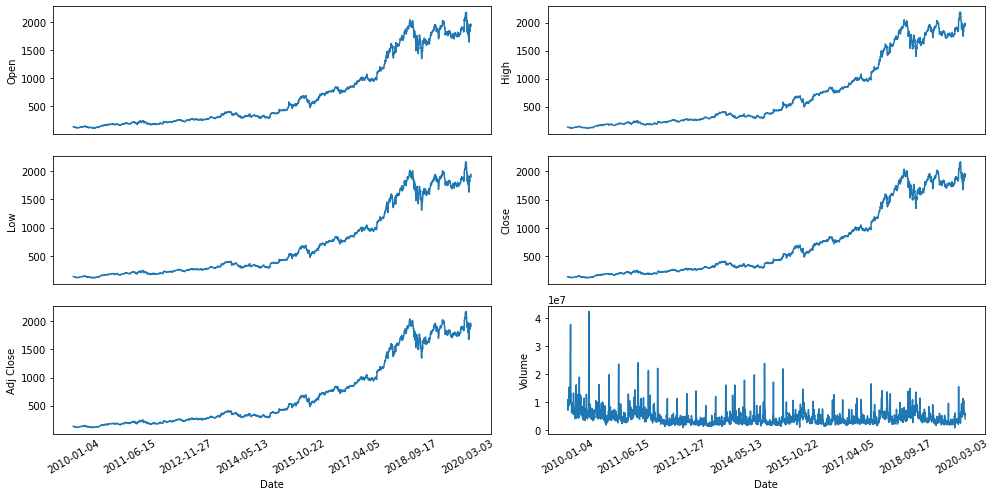

In [10]:
# Plot line charts
df_plot = data_amzn.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

# Split Data 

In [11]:
# Indexing Batches
train_df = data_amzn.sort_values(by=['Date']).copy()

# List of considered Features
FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume']

# Create the dataset with features and filter the data to the list of FEATURES
dataset = pd.DataFrame(train_df)
data_amzn_filtered = dataset[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_amzn_filtered['Prediction'] = data_amzn_filtered['Close']

# Print the tail of the dataframe
data_amzn_filtered.tail()

,High,Low,Open,Close,Volume,Prediction
Date,,,,,,
2020-03-26,1956.489990,1889.290039,1902.000000,1955.489990,6221300,1955.489990
2020-03-27,1939.790039,1899.920044,1930.859985,1900.099976,5387900,1900.099976
2020-03-30,1973.630005,1912.339966,1922.829956,1963.949951,6126100,1963.949951
2020-03-31,1993.020020,1944.010010,1964.349976,1949.719971,5123600,1949.719971
2020-04-01,1944.959961,1893.000000,1932.969971,1907.699951,4111100,1907.699951


## Scaling 

In [12]:
# Get the number of rows in the data
nrows = data_amzn_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_amzn_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_amzn_filtered['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)
np_Close_scaled

(2579, 6)


array([[0.01226711],
       [0.01265031],
       [0.01146677],
       ...,
       [0.89994712],
       [0.89304475],
       [0.87266262]])

In [13]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 20

# Prediction Index
index_Close = dataset.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
total_length = len(np_data_scaled)
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len:total_length, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(2044, 20, 6) (2044,)
(495, 20, 6) (495,)
0.004612900730103925
0.004612900730103925


# Training 

## SIMPLE-RNN

In [14]:
def simple_rnn(x_train, learning_rate = 0.001, layer=3):
    if layer == 3:
        # Configure the neural network model
        model_rnn = Sequential()

        # Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
        n_neurons = x_train.shape[1] * x_train.shape[2]
        print(n_neurons, x_train.shape[1], x_train.shape[2])

        # first RNN layer
        model_rnn.add(SimpleRNN(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
        model_rnn.add(Dropout(0.2))      # dropout regularisation

        # second RNN layer
        model_rnn.add(SimpleRNN(n_neurons, return_sequences=True))

        # third RNN layer
        model_rnn.add(SimpleRNN(n_neurons))

        # adding dense layer
        model_rnn.add(Dense(5))

        # adding output layer
        model_rnn.add(Dense(1))

        opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
        # Compile the model
        model_rnn.compile(optimizer= opt, loss='mse')
        
    if layer == 2:
        model_rnn = Sequential()

        # Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
        n_neurons = x_train.shape[1] * x_train.shape[2]
        print(n_neurons, x_train.shape[1], x_train.shape[2])

        # first RNN layer
        model_rnn.add(SimpleRNN(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
        model_rnn.add(Dropout(0.2))      # dropout regularisation

        # second RNN layer
        model_rnn.add(SimpleRNN(n_neurons))

        # adding dense layer
        model_rnn.add(Dense(5))

        # adding output layer
        model_rnn.add(Dense(1))

        opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
        # Compile the model
        model_rnn.compile(optimizer= opt, loss='mse')
        
    if layer == 1:
        
        model_rnn = Sequential()

        # Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
        n_neurons = x_train.shape[1] * x_train.shape[2]
        print(n_neurons, x_train.shape[1], x_train.shape[2])

        # first RNN layer
        model_rnn.add(SimpleRNN(n_neurons, return_sequences=False, input_shape=(x_train.shape[1], x_train.shape[2])))      

        model_rnn.add(Dense(5))

        # adding output layer
        model_rnn.add(Dense(1))

        opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
        # Compile the model
        model_rnn.compile(optimizer= opt, loss='mse')

    return model_rnn

In [15]:
# Training the model
def train_rnn(model, batch_size, x_train, y_train, x_test, y_test):
    epochs = 20
    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
    history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stop])
    
    # Get the predicted values
    y_pred_scaled = model.predict(x_test)
    
    return history, y_pred_scaled

In [16]:
# Plot training & validation loss values
def plot(history):
    fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
    sns.lineplot(data=history.history["loss"])
    sns.lineplot(data=history.history["val_loss"])
    plt.title("Model loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    ax.xaxis.set_major_locator(plt.MaxNLocator(20))
    plt.legend(["Train", "Test"], loc="upper left")
    plt.grid()
    plt.show()

In [17]:
def evaluate_model(y_pred_scaled, y_test):
    # Unscale the predicted values
    y_pred = scaler_pred.inverse_transform(y_pred_scaled)
    y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

    # Mean Absolute Error (MAE)
    MAE = mean_absolute_error(y_test_unscaled, y_pred)
    print(f'Mean Absolute Error (MAE): {np.round(MAE, 2)}')

    # Mean Absolute Percentage Error (MAPE)
    MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
    print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

    # Median Absolute Percentage Error (MDAPE)
    MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
    print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
    
    return y_pred

In [18]:
def line_plot(y_pred):
    # Add the difference between the valid and predicted prices
    train = pd.DataFrame(data_amzn_filtered['Close'][sequence_length:train_data_len + 1]).rename(columns={'Close': 'y_train'})
    valid = pd.DataFrame(data_amzn_filtered['Close'][sequence_length+train_data_len :]).rename(columns={'Close': 'y_test'})
    valid.insert(1, "y_pred", y_pred, True)
    df_union = pd.concat([train, valid])

    # Zoom in to a closer timeframe
    df_union_zoom = df_union[df_union.index > start_date]

    # Create the lineplot
    fig, ax1 = plt.subplots(figsize=(16, 8))
    plt.title("y_pred vs y_test")
    plt.ylabel("Amazon", fontsize=18)
    sns.set_palette(["#090364", "#1960EF", "#EF5919"])
    sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

    plt.legend()
    plt.show()

In [19]:
def predict(model):
    df_temp = data_amzn[-sequence_length:]
    df_temp = df_temp.values
    df_temp[-1][3]
    N = sequence_length

    # Create an empty list and Append past N days
    X_test_new = []
    X_test_new.append(df_temp)

    # Convert the X_test data set to a numpy array and reshape the data
    pred_price_scaled = model.predict(np.array(X_test_new))
    pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

    # Print last price and predicted price for the next day
    price_today = np.round(df_temp[-1][3], 2)
    predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
    change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

    print(f'The close price for Amazon at {end_date} was {price_today}')
    print(f'The predicted close price is {predicted_price}')

Metal device set to: Apple M1
120 20 6
Epoch 1/20


2022-11-24 16:04:16.088460: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-24 16:04:16.088597: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-11-24 16:04:16.186930: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


128/128 [==============================] - 2s 8ms/step - loss: 0.0449 - val_loss: 0.0269
Epoch 2/20
128/128 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0076
Epoch 3/20
128/128 [==============================] - 1s 7ms/step - loss: 7.5611e-04 - val_loss: 0.0072
Epoch 4/20
128/128 [==============================] - 1s 7ms/step - loss: 5.2067e-04 - val_loss: 0.0056
Epoch 5/20
128/128 [==============================] - 1s 7ms/step - loss: 4.9127e-04 - val_loss: 0.0049
Epoch 6/20
128/128 [==============================] - 1s 7ms/step - loss: 4.3204e-04 - val_loss: 0.0011
Epoch 7/20
128/128 [==============================] - 1s 7ms/step - loss: 6.2977e-04 - val_loss: 0.0011
Epoch 8/20
128/128 [==============================] - 1s 7ms/step - loss: 3.2590e-04 - val_loss: 0.0017
Epoch 9/20
128/128 [==============================] - 1s 7ms/step - loss: 3.8175e-04 - val_loss: 0.0012
Epoch 10/20
128/128 [==============================] - 1s 7ms/step - loss: 4.8671e-

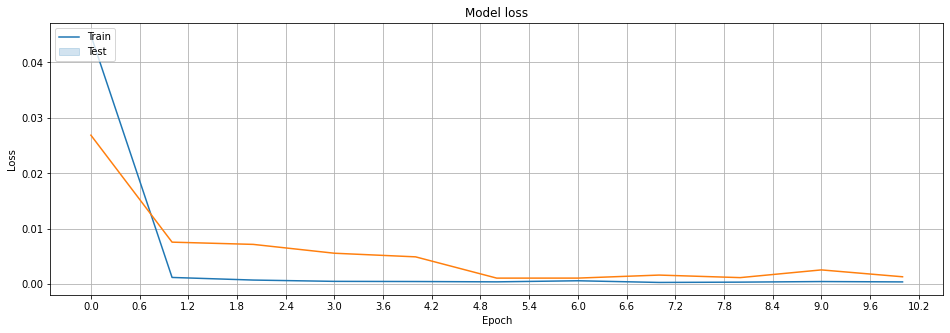

Mean Absolute Error (MAE): 57.64
Mean Absolute Percentage Error (MAPE): 3.16 %
Median Absolute Percentage Error (MDAPE): 2.61 %


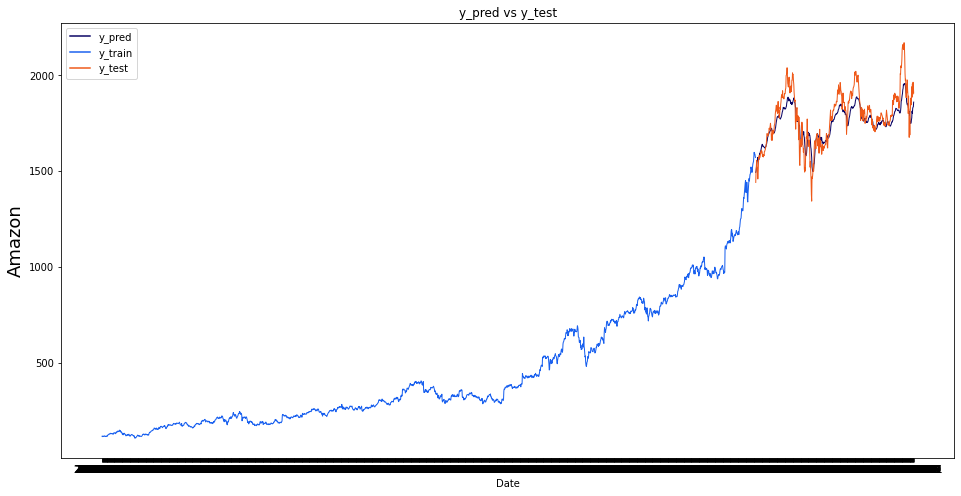

1/1 [==============================] - 0s 6ms/step
The close price for Amazon at 2022-11-24 was 1907.7
The predicted close price is 1349.81005859375


In [20]:
with tf.device('/cpu:0'): 
    model_rnn = simple_rnn(x_train)
    history_rnn_16, y_pred_scaled_rnn_16 = train_rnn(model_rnn, 16, x_train, y_train, x_test, y_test)
    plot(history_rnn_16)
    y_pred_rnn_16 = evaluate_model(y_pred_scaled_rnn_16, y_test)
    line_plot(y_pred_rnn_16)
    predict(model_rnn)

## LSTM

In [21]:
def lstm(x_train, learning_rate = 0.001, layer =3):
    if layer == 3:
        # Configure the neural network model
        model_lstm = Sequential()

        # Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
        n_neurons = x_train.shape[1] * x_train.shape[2]
        print(n_neurons, x_train.shape[1], x_train.shape[2])

        # first LSTM layer
        model_lstm.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
        model_lstm.add(Dropout(0.2))      # dropout regularisation

        # second LSTM layer
        model_lstm.add(LSTM(n_neurons, return_sequences=True))

        # third LSTM layer
        model_lstm.add(LSTM(n_neurons))

        # adding dense layer
        model_lstm.add(Dense(5))

        # adding output layer
        model_lstm.add(Dense(1))

        opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
        # Compile the model
        model_lstm.compile(optimizer = opt, loss='mse')
        
    if layer == 2:
        # Configure the neural network model
        model_lstm = Sequential()

        # Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
        n_neurons = x_train.shape[1] * x_train.shape[2]
        print(n_neurons, x_train.shape[1], x_train.shape[2])

        # first LSTM layer
        model_lstm.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
        model_lstm.add(Dropout(0.2))      # dropout regularisation

        # second LSTM layer
        model_lstm.add(LSTM(n_neurons))

        # adding dense layer
        model_lstm.add(Dense(5))

        # adding output layer
        model_lstm.add(Dense(1))

        opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
        # Compile the model
        model_lstm.compile(optimizer = opt, loss='mse')
        
    if layer == 1:
        # Configure the neural network model
        model_lstm = Sequential()

        # Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
        n_neurons = x_train.shape[1] * x_train.shape[2]
        print(n_neurons, x_train.shape[1], x_train.shape[2])

        # first LSTM layer
        model_lstm.add(LSTM(n_neurons, input_shape=(x_train.shape[1], x_train.shape[2]))) 

        # adding dense layer
        model_lstm.add(Dense(5))

        # adding output layer
        model_lstm.add(Dense(1))

        opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
        # Compile the model
        model_lstm.compile(optimizer = opt, loss='mse')

    return model_lstm

In [22]:
# Training the model
def train_lstm(model, batch_size,x_train, y_train, x_test, y_test):
    epochs = 20
    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
    history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stop])
    
    # Get the predicted values
    y_pred_scaled = model.predict(x_test)
    
    return history, y_pred_scaled

# Evaluate Model 

In [24]:
def evaluate_model(y_pred_scaled, y_test):
    # Unscale the predicted values
    y_pred = scaler_pred.inverse_transform(y_pred_scaled)
    y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

    # Mean Absolute Error (MAE)
    MAE = mean_absolute_error(y_test_unscaled, y_pred)
    print(f'Mean Absolute Error (MAE): {np.round(MAE, 2)}')

    # Mean Absolute Percentage Error (MAPE)
    MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
    print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

    # Median Absolute Percentage Error (MDAPE)
    MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
    print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
    
    return y_pred

# Line Plot

# Predict 

In [26]:
def predict(model):
    df_temp = data_amzn[-sequence_length:]
    df_temp = df_temp.values
    df_temp[-1][3]

    N = sequence_length

    # Create an empty list and Append past N days
    X_test_new = []
    X_test_new.append(df_temp)

    # Convert the X_test data set to a numpy array and reshape the data
    pred_price_scaled = model.predict(np.array(X_test_new))
    pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

    # Print last price and predicted price for the next day
    price_today = np.round(df_temp[-1][3], 2)
    predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
    change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

    print(f'The close price for Amazon at {end_date} was {price_today}')
    print(f'The predicted close price is {predicted_price}')

120 20 6
Epoch 1/20


2022-11-24 16:04:33.549114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:04:33.773260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:04:33.875277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:04:33.924806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:04:34.052343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:04:34.176876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  3/128 [..............................] - ETA: 3s - loss: 0.0329  

2022-11-24 16:04:34.273775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


128/128 [==============================] - ETA: 0s - loss: 0.0014

2022-11-24 16:04:37.556303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:04:37.635402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:04:37.683179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:04:37.728575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


128/128 [==============================] - 6s 30ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 2/20
128/128 [==============================] - 3s 23ms/step - loss: 1.7619e-04 - val_loss: 0.0015
Epoch 3/20
128/128 [==============================] - 3s 23ms/step - loss: 2.0994e-04 - val_loss: 0.0014
Epoch 4/20
128/128 [==============================] - 3s 24ms/step - loss: 1.3392e-04 - val_loss: 0.0036
Epoch 5/20
128/128 [==============================] - 3s 23ms/step - loss: 1.4828e-04 - val_loss: 0.0017
Epoch 6/20
128/128 [==============================] - 3s 23ms/step - loss: 1.5334e-04 - val_loss: 0.0014
Epoch 7/20
128/128 [==============================] - 3s 23ms/step - loss: 1.0639e-04 - val_loss: 0.0013
Epoch 8/20
128/128 [==============================] - 3s 23ms/step - loss: 1.9427e-04 - val_loss: 0.0012
Epoch 9/20
128/128 [==============================] - 3s 24ms/step - loss: 8.9327e-05 - val_loss: 0.0015
Epoch 10/20
128/128 [==============================] - 3s 24ms/step - 

2022-11-24 16:05:37.953462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:05:38.051776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:05:38.110926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/16 [=====================>........] - ETA: 0s

2022-11-24 16:05:38.159375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 1s 14ms/step


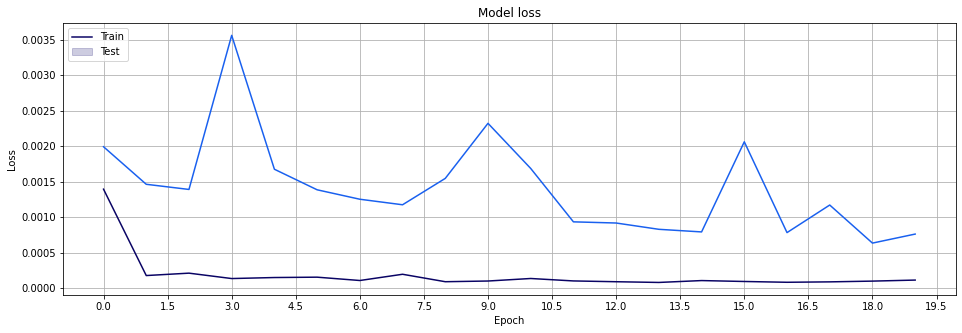

Mean Absolute Error (MAE): 46.01
Mean Absolute Percentage Error (MAPE): 2.59 %
Median Absolute Percentage Error (MDAPE): 2.23 %


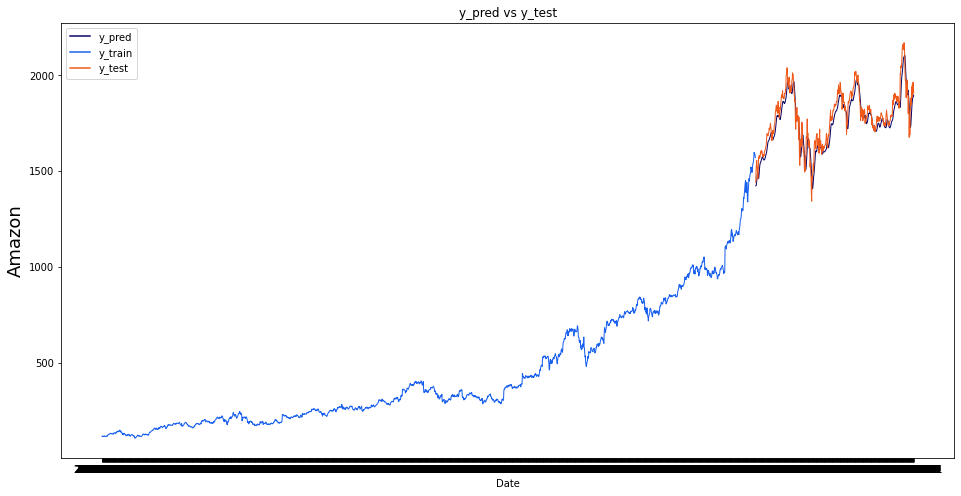

1/1 [==============================] - 0s 114ms/step
The close price for Amazon at 2022-11-24 was 1907.7
The predicted close price is 2987.889892578125


In [27]:
# batch_size 16
model_lstm = lstm(x_train)
history_lstm_16, y_pred_scaled_lstm_16 = train_lstm(model_lstm, 16, x_train, y_train, x_test, y_test)
plot(history_lstm_16)
y_pred_lstm_16 = evaluate_model(y_pred_scaled_lstm_16, y_test)
line_plot(y_pred_lstm_16)
predict(model_lstm)

# GRU

In [28]:
def gru(x_train, learning_rate = 0.001, layer =3):
    if layer == 3:
        # Configure the neural network model
        model_gru = Sequential()

        # Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
        n_neurons = x_train.shape[1] * x_train.shape[2]
        print(n_neurons, x_train.shape[1], x_train.shape[2])

        # first GRU layer
        model_gru.add(GRU(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
        model_gru.add(Dropout(0.2))      # dropout regularisation

        # second GRU layer
        model_gru.add(GRU(n_neurons, return_sequences=True))

        #  third GRU layer
        model_gru.add(GRU(n_neurons))

        # adding dense layer
        model_gru.add(Dense(5))

        # adding output layer
        model_gru.add(Dense(1))

        opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
        # Compile the model
        model_gru.compile(optimizer=opt , loss='mse')
        
    if layer == 2:
        # Configure the neural network model
        model_gru = Sequential()

        # Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
        n_neurons = x_train.shape[1] * x_train.shape[2]
        print(n_neurons, x_train.shape[1], x_train.shape[2])

        # first LSTM layer
        model_gru.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
        model_gru.add(Dropout(0.2))      # dropout regularisation

        # second LSTM layer
        model_gru.add(LSTM(n_neurons))

        # adding dense layer
        model_gru.add(Dense(5))

        # adding output layer
        model_gru.add(Dense(1))

        opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
        # Compile the model
        model_gru.compile(optimizer = opt, loss='mse')
    
    if layer == 1:
        # Configure the neural network model
        model_gru = Sequential()

        # Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
        n_neurons = x_train.shape[1] * x_train.shape[2]
        print(n_neurons, x_train.shape[1], x_train.shape[2])

        # first LSTM layer
        model_gru.add(LSTM(n_neurons, input_shape=(x_train.shape[1], x_train.shape[2]))) 

        # adding dense layer
        model_gru.add(Dense(5))

        # adding output layer
        model_gru.add(Dense(1))

        opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
        # Compile the model
        model_gru.compile(optimizer = opt, loss='mse')
    
    return model_gru

In [29]:
# Training the model
def train_gru(model, batch_size, x_train, y_train, x_test, y_test):
    epochs = 20
    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
    history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stop])
    
    # Get the predicted values
    y_pred_scaled = model.predict(x_test)
    
    return history, y_pred_scaled

In [31]:
def evaluate_model(y_pred_scaled, y_test):
    # Unscale the predicted values
    y_pred = scaler_pred.inverse_transform(y_pred_scaled)
    y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

    # Mean Absolute Error (MAE)
    MAE = mean_absolute_error(y_test_unscaled, y_pred)
    print(f'Mean Absolute Error (MAE): {np.round(MAE, 2)}')

    # Mean Absolute Percentage Error (MAPE)
    MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
    print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

    # Median Absolute Percentage Error (MDAPE)
    MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
    print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
    
    return y_pred

In [33]:
def predict(model):
    df_temp = data_amzn[-sequence_length:]
    df_temp = df_temp.values
    df_temp[-1][3]
    # new_df = df_temp.filter(FEATURES)

    N = sequence_length

    # Get the last N day closing price values and scale the data to be values between 0 and 1
    # last_N_days = new_df[-sequence_length:].values
    # last_N_days_scaled = scaler.transform(last_N_days)

    # Create an empty list and Append past N days
    X_test_new = []
    X_test_new.append(df_temp)

    # Convert the X_test data set to a numpy array and reshape the data
    pred_price_scaled = model.predict(np.array(X_test_new))
    pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

    # Print last price and predicted price for the next day
    price_today = np.round(df_temp[-1][3], 2)
    predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
    change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

    print(f'The close price for Amazon at {end_date} was {price_today}')
    print(f'The predicted close price is {predicted_price} ')

120 20 6
Epoch 1/20


2022-11-24 16:05:45.271760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:05:45.493818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:05:45.595065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:05:45.667097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:05:45.762296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:05:45.871242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  3/128 [..............................] - ETA: 4s - loss: 0.0111  

2022-11-24 16:05:45.985888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


128/128 [==============================] - ETA: 0s - loss: 7.2928e-04

2022-11-24 16:05:49.560160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:05:49.630841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:05:49.682569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:05:49.733549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


128/128 [==============================] - 7s 32ms/step - loss: 7.2928e-04 - val_loss: 7.5646e-04
Epoch 2/20
128/128 [==============================] - 3s 26ms/step - loss: 8.1619e-05 - val_loss: 9.8685e-04
Epoch 3/20
128/128 [==============================] - 4s 28ms/step - loss: 9.0238e-05 - val_loss: 8.1840e-04
Epoch 4/20
128/128 [==============================] - 4s 29ms/step - loss: 1.0278e-04 - val_loss: 0.0025
Epoch 5/20
128/128 [==============================] - 4s 28ms/step - loss: 1.2248e-04 - val_loss: 0.0016
Epoch 6/20
128/128 [==============================] - 4s 28ms/step - loss: 8.7767e-05 - val_loss: 6.5489e-04
Epoch 7/20
128/128 [==============================] - 4s 28ms/step - loss: 8.8880e-05 - val_loss: 0.0011
Epoch 8/20
128/128 [==============================] - 4s 29ms/step - loss: 8.3434e-05 - val_loss: 0.0011
Epoch 9/20
128/128 [==============================] - 3s 27ms/step - loss: 1.2468e-04 - val_loss: 8.3481e-04
Epoch 10/20
128/128 [=========================

2022-11-24 16:06:25.826139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:06:25.893100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:06:25.950200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:06:26.002998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 1s 16ms/step


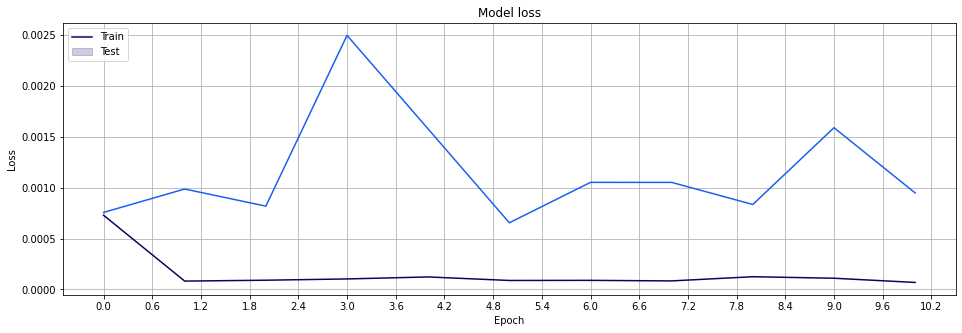

Mean Absolute Error (MAE): 49.25
Mean Absolute Percentage Error (MAPE): 2.81 %
Median Absolute Percentage Error (MDAPE): 2.23 %


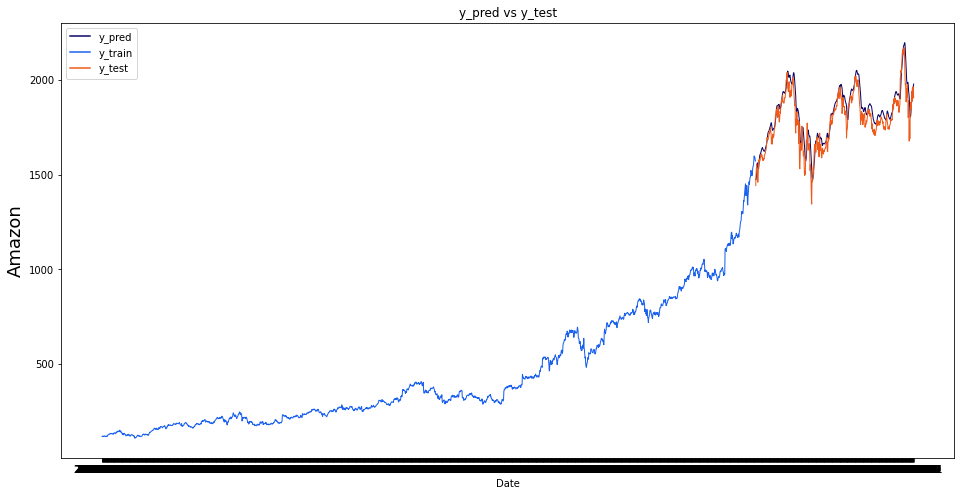

1/1 [==============================] - 0s 109ms/step
The close price for Amazon at 2022-11-24 was 1907.7
The predicted close price is 1575.1300048828125 


In [34]:
# batch_size 16
model_gru = gru(x_train)
history_gru_16, y_pred_scaled_gru_16 = train_gru(model_gru, 16, x_train, y_train, x_test, y_test)
plot(history_gru_16)
y_pred_gru_16 = evaluate_model(y_pred_scaled_gru_16, y_test)
line_plot(y_pred_gru_16)
predict(model_gru)

# Experimenting

# Changing Learning_rate

### learning_rate = 0.1

120 20 6
Epoch 1/20
128/128 [==============================] - 2s 8ms/step - loss: 2.2450 - val_loss: 0.4327
Epoch 2/20
128/128 [==============================] - 1s 7ms/step - loss: 0.0240 - val_loss: 0.5014
Epoch 3/20
128/128 [==============================] - 1s 7ms/step - loss: 0.0248 - val_loss: 0.5494
Epoch 4/20
128/128 [==============================] - 1s 7ms/step - loss: 0.0249 - val_loss: 0.4309
Epoch 5/20
128/128 [==============================] - 1s 7ms/step - loss: 0.0246 - val_loss: 0.4433
Epoch 6/20
128/128 [==============================] - 1s 7ms/step - loss: 0.0239 - val_loss: 0.4699
Epoch 7/20
128/128 [==============================] - 1s 7ms/step - loss: 0.0243 - val_loss: 0.4507
Epoch 8/20
128/128 [==============================] - 1s 7ms/step - loss: 0.0244 - val_loss: 0.4423
Epoch 9/20
128/128 [==============================] - 1s 7ms/step - loss: 0.0245 - val_loss: 0.3839
Epoch 10/20
128/128 [==============================] - 1s 7ms/step - loss: 0.0245 - val_los

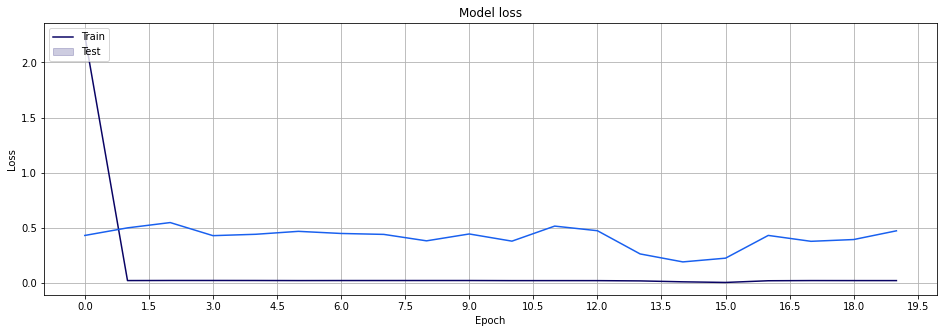

Mean Absolute Error (MAE): 1413.38
Mean Absolute Percentage Error (MAPE): 79.06 %
Median Absolute Percentage Error (MDAPE): 79.23 %


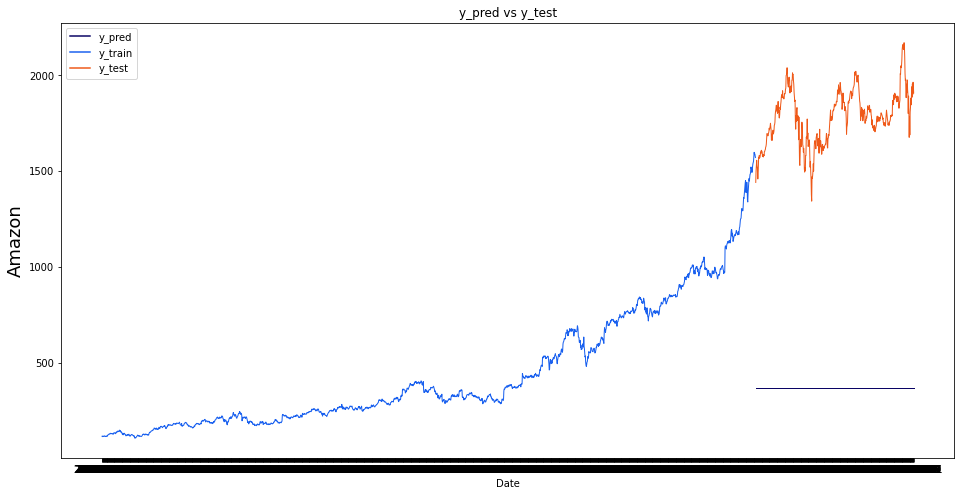

1/1 [==============================] - 0s 6ms/step
The close price for Amazon at 2022-11-24 was 1907.7
The predicted close price is 361.9100036621094 


In [35]:
# For rnn 
with tf.device('/cpu:0'):
    model_rnn_lr1 = simple_rnn(x_train, 0.1)
    history_rnn_lr1, y_pred_scaled_rnn_lr1 = train_rnn(model_rnn_lr1, 16, x_train, y_train, x_test, y_test)
    plot(history_rnn_lr1)
    y_pred_rnn_lr1 = evaluate_model(y_pred_scaled_rnn_lr1, y_test)
    line_plot(y_pred_rnn_lr1)
    predict(model_rnn_lr1)

120 20 6
Epoch 1/20


2022-11-24 16:06:56.489048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:06:56.712983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:06:56.790237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:06:56.848049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:06:56.943812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:06:57.033325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:06:57.142599: I tensorflow/core/grappler/optimizers/cust

128/128 [==============================] - ETA: 0s - loss: 4.2608

2022-11-24 16:07:00.674226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:07:00.752427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:07:00.807538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:07:00.867194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


128/128 [==============================] - 7s 32ms/step - loss: 4.2608 - val_loss: 0.2766
Epoch 2/20
128/128 [==============================] - 3s 24ms/step - loss: 0.0045 - val_loss: 0.0865
Epoch 3/20
128/128 [==============================] - 3s 24ms/step - loss: 0.0018 - val_loss: 0.0707
Epoch 4/20
128/128 [==============================] - 3s 24ms/step - loss: 9.5760e-04 - val_loss: 0.0475
Epoch 5/20
128/128 [==============================] - 3s 25ms/step - loss: 5.7528e-04 - val_loss: 0.0384
Epoch 6/20
128/128 [==============================] - 3s 27ms/step - loss: 7.3263e-04 - val_loss: 0.0376
Epoch 7/20
128/128 [==============================] - 3s 25ms/step - loss: 4.4766e-04 - val_loss: 0.0306
Epoch 8/20
128/128 [==============================] - 3s 24ms/step - loss: 4.6042e-04 - val_loss: 0.0227
Epoch 9/20
128/128 [==============================] - 3s 25ms/step - loss: 6.4594e-04 - val_loss: 0.0373
Epoch 10/20
128/128 [==============================] - 3s 26ms/step - loss: 5.

2022-11-24 16:08:02.009211: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:08:02.103897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:08:02.181448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 8/16 [==============>...............] - ETA: 0s

2022-11-24 16:08:02.236860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 1s 18ms/step


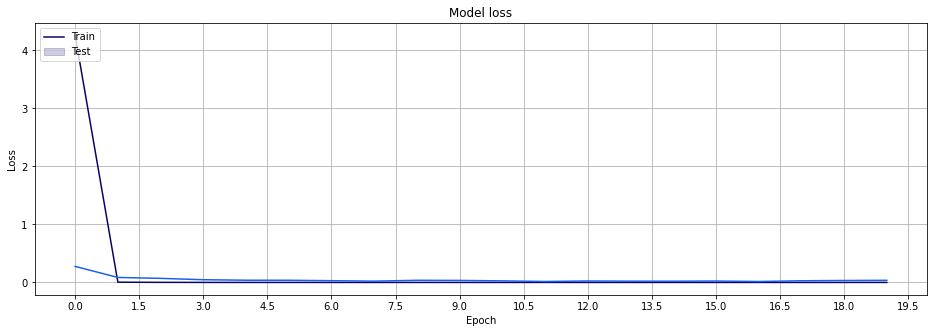

Mean Absolute Error (MAE): 378.03
Mean Absolute Percentage Error (MAPE): 20.77 %
Median Absolute Percentage Error (MDAPE): 20.97 %


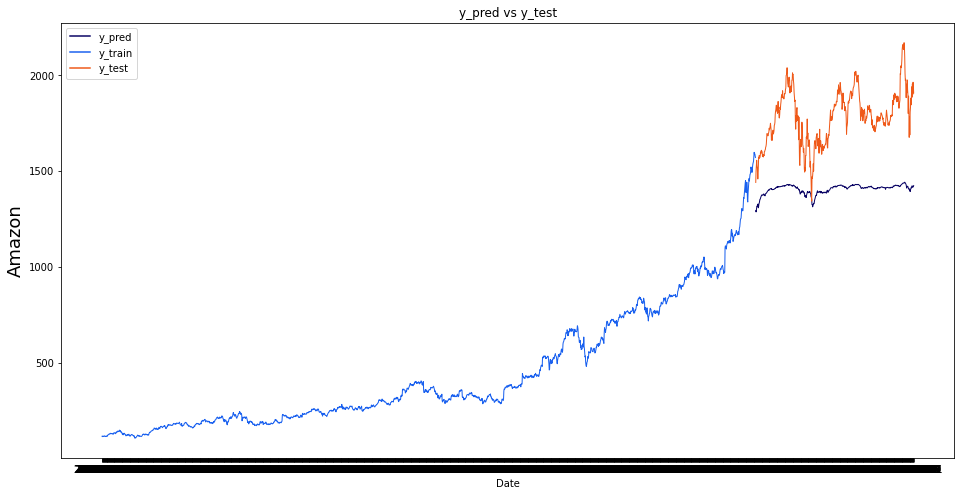

1/1 [==============================] - 0s 123ms/step
The close price for Amazon at 2022-11-24 was 1907.7
The predicted close price is 861.9099731445312 


In [36]:
# For lstm
model_lstm_lr1 = lstm(x_train, 0.1)
history_lstm_lr1, y_pred_scaled_lstm_lr1 = train_lstm(model_lstm_lr1, 16, x_train, y_train, x_test, y_test)
plot(history_lstm_lr1)
y_pred_lstm_lr1 = evaluate_model(y_pred_scaled_lstm_lr1, y_test)
line_plot(y_pred_lstm_lr1)
predict(model_lstm_lr1)

120 20 6
Epoch 1/20


2022-11-24 16:08:09.271886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:08:09.500096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:08:09.597393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:08:09.664701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:08:09.783612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:08:09.893214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  2/128 [..............................] - ETA: 8s - loss: 233.3029

2022-11-24 16:08:10.009403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


128/128 [==============================] - ETA: 0s - loss: 12.6797

2022-11-24 16:08:13.943543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:08:14.021993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:08:14.075486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:08:14.128734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


128/128 [==============================] - 7s 36ms/step - loss: 12.6797 - val_loss: 0.4160
Epoch 2/20
128/128 [==============================] - 3s 26ms/step - loss: 0.0241 - val_loss: 0.3230
Epoch 3/20
128/128 [==============================] - 3s 26ms/step - loss: 0.0250 - val_loss: 0.4414
Epoch 4/20
128/128 [==============================] - 3s 26ms/step - loss: 0.0265 - val_loss: 0.4881
Epoch 5/20
128/128 [==============================] - 3s 26ms/step - loss: 0.0255 - val_loss: 0.4836
Epoch 6/20
128/128 [==============================] - 3s 26ms/step - loss: 0.0265 - val_loss: 0.4919
Epoch 7/20
128/128 [==============================] - 3s 26ms/step - loss: 0.0265 - val_loss: 0.5891
Epoch 7: early stopping


2022-11-24 16:08:35.109945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:08:35.177850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:08:35.245532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:08:35.304655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 1s 18ms/step


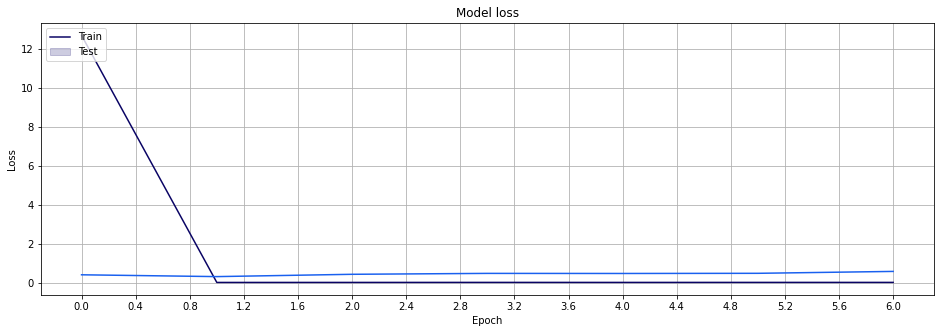

Mean Absolute Error (MAE): 1576.03
Mean Absolute Percentage Error (MAPE): 88.23 %
Median Absolute Percentage Error (MDAPE): 88.33 %


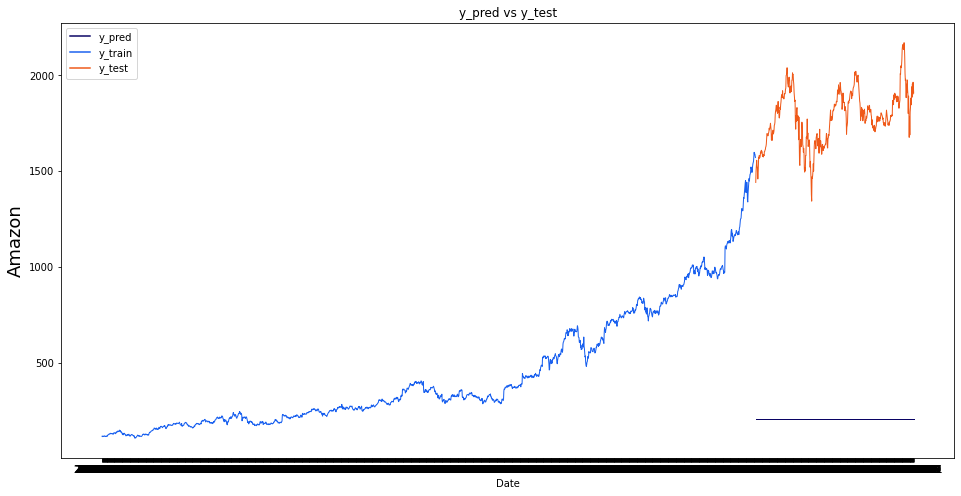

1/1 [==============================] - 0s 100ms/step
The close price for Amazon at 2022-11-24 was 1907.7
The predicted close price is 208.72000122070312 


In [37]:
# For gru
model_gru_lr1 = gru(x_train, 0.1)
history_gru_lr1, y_pred_scaled_gru_lr1 = train_gru(model_gru_lr1, 16, x_train, y_train, x_test, y_test)
plot(history_gru_lr1)
y_pred_gru_lr1 = evaluate_model(y_pred_scaled_gru_lr1, y_test)
line_plot(y_pred_gru_lr1)
predict(model_gru_lr1)

### learning_rate = 0.01

120 20 6
Epoch 1/20
128/128 [==============================] - 2s 10ms/step - loss: 0.4744 - val_loss: 0.4832
Epoch 2/20
128/128 [==============================] - 1s 7ms/step - loss: 0.0225 - val_loss: 0.0976
Epoch 3/20
128/128 [==============================] - 1s 7ms/step - loss: 0.0033 - val_loss: 0.0768
Epoch 4/20
128/128 [==============================] - 1s 7ms/step - loss: 0.0021 - val_loss: 0.0309
Epoch 5/20
128/128 [==============================] - 1s 7ms/step - loss: 0.0012 - val_loss: 0.0093
Epoch 6/20
128/128 [==============================] - 1s 7ms/step - loss: 0.0022 - val_loss: 0.0167
Epoch 7/20
128/128 [==============================] - 1s 7ms/step - loss: 0.0021 - val_loss: 0.0338
Epoch 8/20
128/128 [==============================] - 1s 7ms/step - loss: 0.0067 - val_loss: 0.0433
Epoch 9/20
128/128 [==============================] - 1s 7ms/step - loss: 0.0072 - val_loss: 0.0388
Epoch 10/20
128/128 [==============================] - 1s 7ms/step - loss: 0.0023 - val_lo

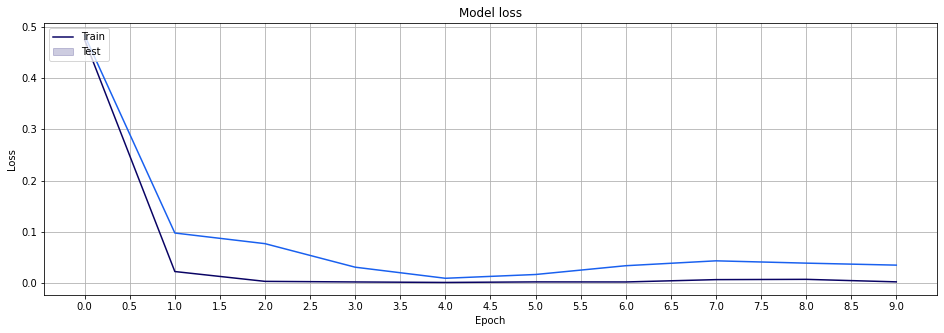

Mean Absolute Error (MAE): 361.46
Mean Absolute Percentage Error (MAPE): 19.78 %
Median Absolute Percentage Error (MDAPE): 20.33 %


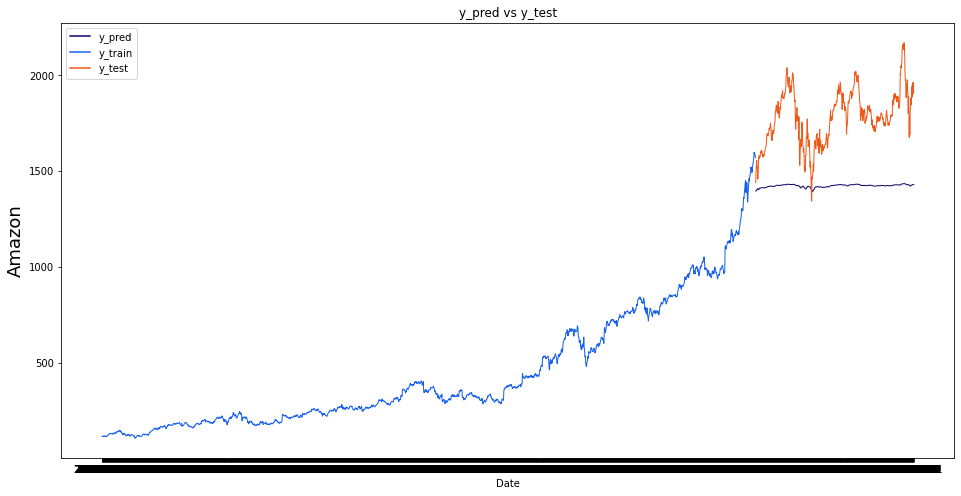

1/1 [==============================] - 0s 9ms/step
The close price for Amazon at 2022-11-24 was 1907.7
The predicted close price is 1133.18994140625 


In [38]:
# For rnn 
with tf.device('/cpu:0'):
    model_rnn_lr01 = simple_rnn(x_train, 0.01)
    history_rnn_lr01, y_pred_scaled_rnn_lr01 = train_rnn(model_rnn_lr01, 16, x_train, y_train, x_test, y_test)
    plot(history_rnn_lr01)
    y_pred_rnn_lr01 = evaluate_model(y_pred_scaled_rnn_lr01, y_test)
    line_plot(y_pred_rnn_lr01)
    predict(model_rnn_lr01)

120 20 6
Epoch 1/20


2022-11-24 16:08:57.615394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:08:57.845621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:08:57.943909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:08:58.016237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:08:58.154024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:08:58.268346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  2/128 [..............................] - ETA: 9s - loss: 1.0411  

2022-11-24 16:08:58.397686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


128/128 [==============================] - ETA: 0s - loss: 0.0294

2022-11-24 16:09:02.232912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:09:02.311859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:09:02.369792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:09:02.426084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


128/128 [==============================] - 7s 35ms/step - loss: 0.0294 - val_loss: 0.0033
Epoch 2/20
128/128 [==============================] - 3s 25ms/step - loss: 1.4022e-04 - val_loss: 0.0026
Epoch 3/20
128/128 [==============================] - 3s 25ms/step - loss: 1.4415e-04 - val_loss: 0.0020
Epoch 4/20
128/128 [==============================] - 3s 24ms/step - loss: 1.5626e-04 - val_loss: 0.0045
Epoch 5/20
128/128 [==============================] - 3s 24ms/step - loss: 1.2692e-04 - val_loss: 0.0085
Epoch 6/20
128/128 [==============================] - 3s 24ms/step - loss: 1.1843e-04 - val_loss: 0.0056
Epoch 7/20
128/128 [==============================] - 3s 24ms/step - loss: 1.4062e-04 - val_loss: 0.0034
Epoch 8/20
128/128 [==============================] - 3s 24ms/step - loss: 1.3176e-04 - val_loss: 0.0030
Epoch 8: early stopping


2022-11-24 16:09:25.343136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:09:25.431891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:09:25.493119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/16 [=================>............] - ETA: 0s

2022-11-24 16:09:25.554176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 1s 16ms/step


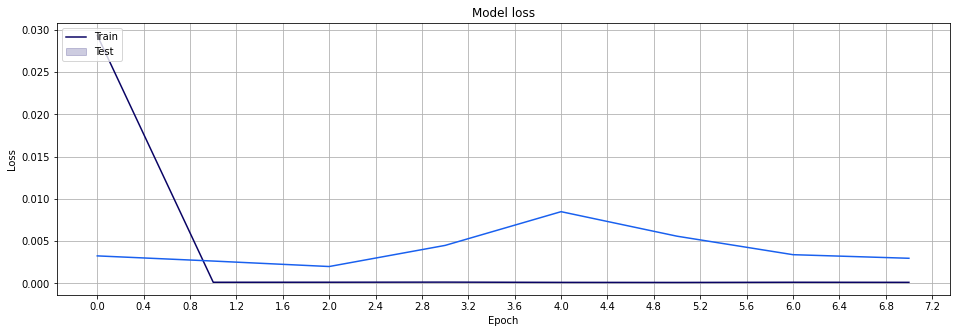

Mean Absolute Error (MAE): 82.51
Mean Absolute Percentage Error (MAPE): 4.69 %
Median Absolute Percentage Error (MDAPE): 3.17 %


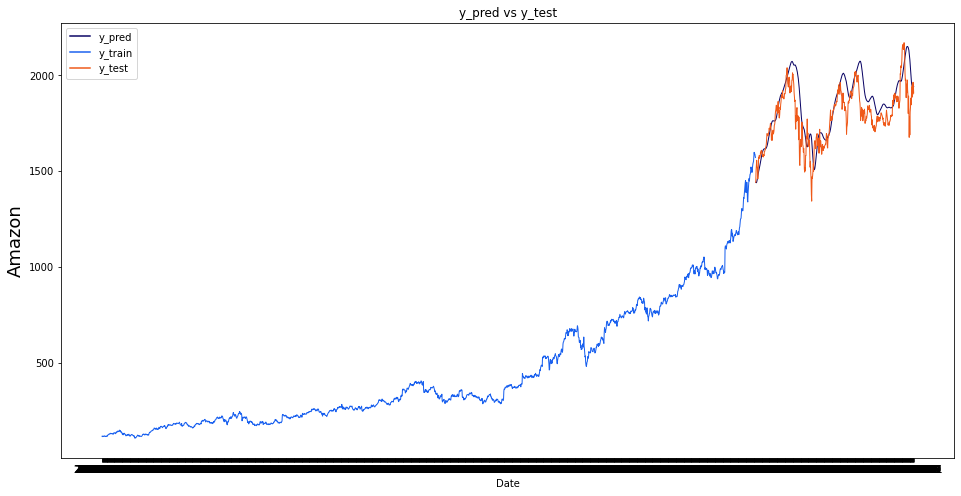

1/1 [==============================] - 0s 93ms/step
The close price for Amazon at 2022-11-24 was 1907.7
The predicted close price is 2050.8701171875 


In [39]:
# For lstm
model_lstm_lr01 = lstm(x_train, 0.01)
history_lstm_lr01, y_pred_scaled_lstm_lr01 = train_lstm(model_lstm_lr01, 16, x_train, y_train, x_test, y_test)
plot(history_lstm_lr01)
y_pred_lstm_lr01 = evaluate_model(y_pred_scaled_lstm_lr01, y_test)
line_plot(y_pred_lstm_lr01)
predict(model_lstm_lr01)

120 20 6
Epoch 1/20


2022-11-24 16:09:32.583690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:09:32.805578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:09:32.885312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:09:32.946299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:09:33.072147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:09:33.170950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  2/128 [..............................] - ETA: 8s - loss: 4.7952  

2022-11-24 16:09:33.333021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


128/128 [==============================] - ETA: 0s - loss: 0.0884

2022-11-24 16:09:37.237354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:09:37.310943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:09:37.367247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:09:37.422701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


128/128 [==============================] - 7s 36ms/step - loss: 0.0884 - val_loss: 7.6272e-04
Epoch 2/20
128/128 [==============================] - 3s 25ms/step - loss: 9.9884e-05 - val_loss: 7.7942e-04
Epoch 3/20
128/128 [==============================] - 3s 26ms/step - loss: 7.8188e-05 - val_loss: 5.5411e-04
Epoch 4/20
128/128 [==============================] - 3s 26ms/step - loss: 6.7256e-05 - val_loss: 9.1701e-04
Epoch 5/20
128/128 [==============================] - 3s 26ms/step - loss: 6.4140e-05 - val_loss: 0.0011
Epoch 6/20
128/128 [==============================] - 3s 26ms/step - loss: 6.8376e-05 - val_loss: 8.3489e-04
Epoch 7/20
128/128 [==============================] - 3s 26ms/step - loss: 5.7160e-05 - val_loss: 0.0014
Epoch 8/20
128/128 [==============================] - 3s 26ms/step - loss: 6.2551e-05 - val_loss: 8.5128e-04
Epoch 8: early stopping


2022-11-24 16:10:01.277642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:10:01.350215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:10:01.426159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 5/16 [========>.....................] - ETA: 0s

2022-11-24 16:10:01.505713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 1s 20ms/step


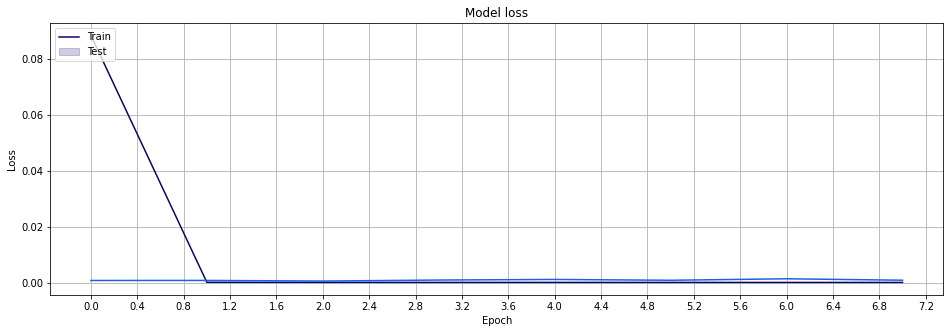

Mean Absolute Error (MAE): 45.53
Mean Absolute Percentage Error (MAPE): 2.59 %
Median Absolute Percentage Error (MDAPE): 2.0 %


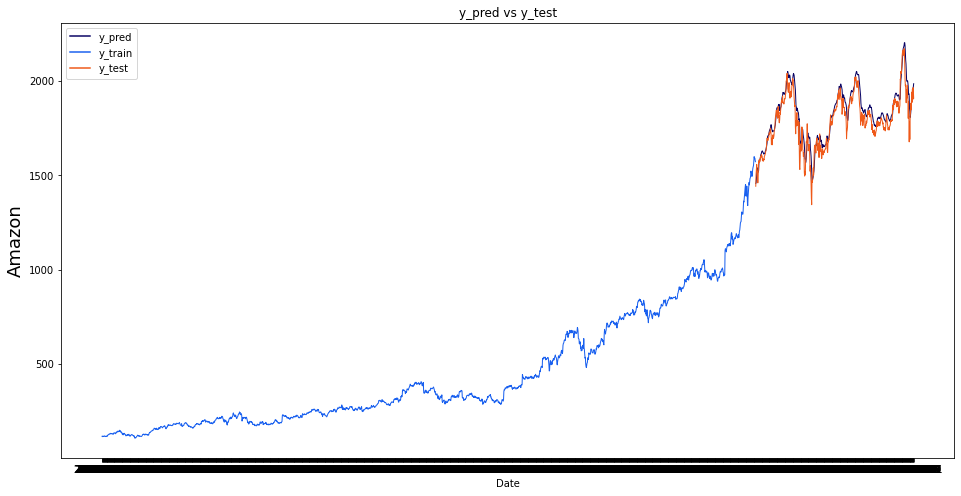

1/1 [==============================] - 0s 122ms/step
The close price for Amazon at 2022-11-24 was 1907.7
The predicted close price is 4795.18994140625 


In [40]:
# For gru
model_gru_lr01 = gru(x_train, 0.01)
history_gru_lr01, y_pred_scaled_gru_lr01 = train_gru(model_gru_lr01, 16, x_train, y_train, x_test, y_test)
plot(history_gru_lr01)
y_pred_gru_lr01 = evaluate_model(y_pred_scaled_gru_lr01, y_test)
line_plot(y_pred_gru_lr01)
predict(model_gru_lr01)

## Changing Batch_size

### Batch_size = 30

120 20 6
Epoch 1/20
69/69 [==============================] - 2s 11ms/step - loss: 0.1908 - val_loss: 0.0231
Epoch 2/20
69/69 [==============================] - 1s 9ms/step - loss: 0.0056 - val_loss: 0.0102
Epoch 3/20
69/69 [==============================] - 1s 10ms/step - loss: 0.0028 - val_loss: 0.0052
Epoch 4/20
69/69 [==============================] - 1s 10ms/step - loss: 0.0020 - val_loss: 0.0214
Epoch 5/20
69/69 [==============================] - 1s 10ms/step - loss: 0.0013 - val_loss: 0.0050
Epoch 6/20
69/69 [==============================] - 1s 10ms/step - loss: 0.0013 - val_loss: 0.0059
Epoch 7/20
69/69 [==============================] - 1s 10ms/step - loss: 7.8122e-04 - val_loss: 0.0094
Epoch 8/20
69/69 [==============================] - 1s 10ms/step - loss: 7.1803e-04 - val_loss: 0.0017
Epoch 9/20
69/69 [==============================] - 1s 10ms/step - loss: 7.3879e-04 - val_loss: 0.0049
Epoch 10/20
69/69 [==============================] - 1s 10ms/step - loss: 4.9300e-04 - va

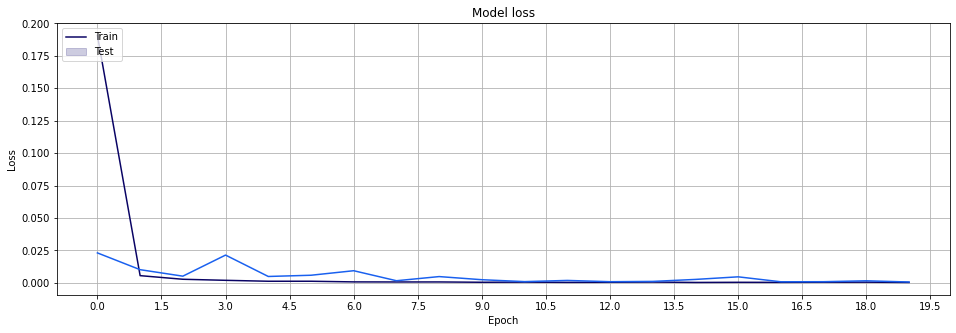

Mean Absolute Error (MAE): 39.94
Mean Absolute Percentage Error (MAPE): 2.27 %
Median Absolute Percentage Error (MDAPE): 1.73 %


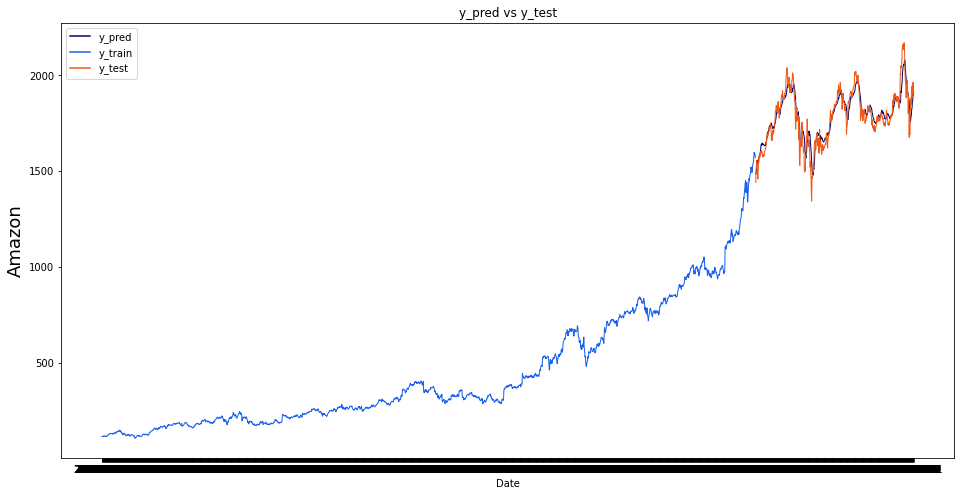

1/1 [==============================] - 0s 7ms/step
The close price for Amazon at 2022-11-24 was 1907.7
The predicted close price is -316.7699890136719 


In [41]:
with tf.device('/cpu:0'):
    # For rnn 
    model_rnn_b30 = simple_rnn(x_train)
    history_rnn_b30, y_pred_scaled_rnn_b30 = train_rnn(model_rnn_b30, 30, x_train, y_train, x_test, y_test)
    plot(history_rnn_b30)
    y_pred_rnn_b30 = evaluate_model(y_pred_scaled_rnn_b30, y_test)
    line_plot(y_pred_rnn_b30)
    predict(model_rnn_b30)

120 20 6
Epoch 1/20


2022-11-24 16:10:28.033111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:10:28.269920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:10:28.358933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:10:28.450629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:10:28.638579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:10:28.790871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/69 [..............................] - ETA: 2:55 - loss: 0.0336

2022-11-24 16:10:28.935567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


69/69 [==============================] - ETA: 0s - loss: 0.0018

2022-11-24 16:10:31.806922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:10:31.892549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:10:31.972119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:10:32.053939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


69/69 [==============================] - 6s 51ms/step - loss: 0.0018 - val_loss: 0.0025
Epoch 2/20
69/69 [==============================] - 2s 27ms/step - loss: 1.4540e-04 - val_loss: 0.0019
Epoch 3/20
69/69 [==============================] - 2s 27ms/step - loss: 1.2383e-04 - val_loss: 0.0019
Epoch 4/20
69/69 [==============================] - 2s 26ms/step - loss: 1.2710e-04 - val_loss: 0.0039
Epoch 5/20
69/69 [==============================] - 2s 26ms/step - loss: 1.3603e-04 - val_loss: 0.0022
Epoch 6/20
69/69 [==============================] - 2s 25ms/step - loss: 1.3074e-04 - val_loss: 0.0015
Epoch 7/20
69/69 [==============================] - 2s 25ms/step - loss: 1.8184e-04 - val_loss: 0.0080
Epoch 8/20
69/69 [==============================] - 2s 27ms/step - loss: 1.4697e-04 - val_loss: 0.0013
Epoch 9/20
69/69 [==============================] - 2s 25ms/step - loss: 1.0396e-04 - val_loss: 0.0014
Epoch 10/20
69/69 [==============================] - 2s 25ms/step - loss: 1.5602e-04 - v

2022-11-24 16:10:54.311957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:10:54.396416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:10:54.484817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 4/16 [======>.......................] - ETA: 0s 

2022-11-24 16:10:54.568664: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 1s 20ms/step


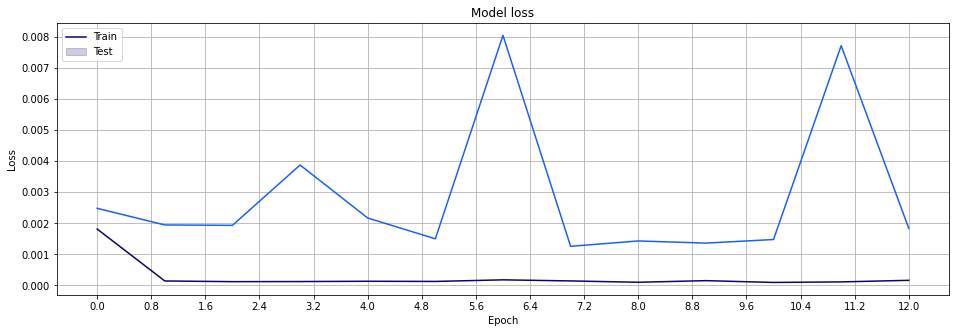

Mean Absolute Error (MAE): 68.63
Mean Absolute Percentage Error (MAPE): 3.91 %
Median Absolute Percentage Error (MDAPE): 3.24 %


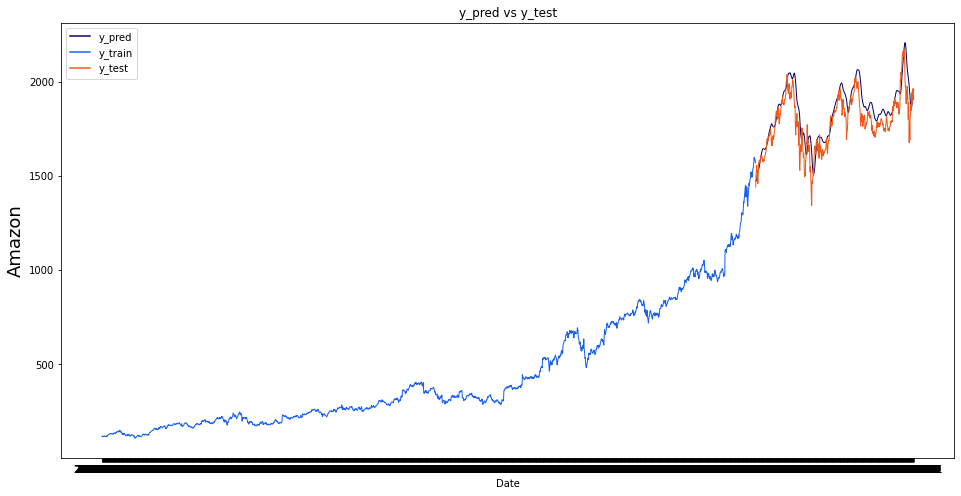

1/1 [==============================] - 0s 128ms/step
The close price for Amazon at 2022-11-24 was 1907.7
The predicted close price is 2161.06005859375 


In [42]:
# For lstm
model_lstm_b30 = lstm(x_train)
history_lstm_b30, y_pred_scaled_lstm_b30 = train_lstm(model_lstm_b30, 30, x_train, y_train, x_test, y_test)
plot(history_lstm_b30)
y_pred_lstm_b30 = evaluate_model(y_pred_scaled_lstm_b30, y_test)
line_plot(y_pred_lstm_b30)
predict(model_lstm_b30)

120 20 6
Epoch 1/20


2022-11-24 16:11:02.023714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:11:02.266410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:11:02.380038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:11:02.462725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:11:02.623128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:11:02.765735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/69 [..............................] - ETA: 3:03 - loss: 0.0228

2022-11-24 16:11:02.920831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


69/69 [==============================] - ETA: 0s - loss: 9.7107e-04

2022-11-24 16:11:05.738140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:11:05.812427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:11:05.885511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:11:05.957880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


69/69 [==============================] - 6s 50ms/step - loss: 9.7107e-04 - val_loss: 7.4567e-04
Epoch 2/20
69/69 [==============================] - 2s 25ms/step - loss: 8.6696e-05 - val_loss: 8.1121e-04
Epoch 3/20
69/69 [==============================] - 2s 25ms/step - loss: 8.3082e-05 - val_loss: 7.6973e-04
Epoch 4/20
69/69 [==============================] - 2s 26ms/step - loss: 1.1008e-04 - val_loss: 7.4596e-04
Epoch 5/20
69/69 [==============================] - 2s 25ms/step - loss: 9.6594e-05 - val_loss: 8.5950e-04
Epoch 6/20
69/69 [==============================] - 2s 26ms/step - loss: 9.7393e-05 - val_loss: 0.0034
Epoch 6: early stopping


2022-11-24 16:11:15.567503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:11:15.634059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:11:15.711780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 6/16 [==========>...................] - ETA: 0s

2022-11-24 16:11:15.788761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 1s 20ms/step


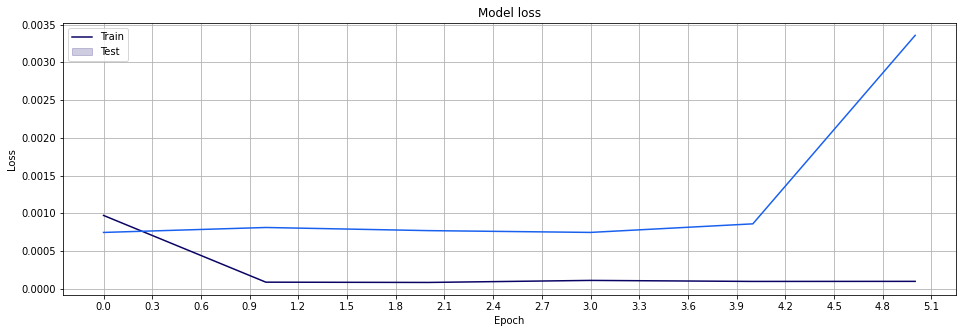

Mean Absolute Error (MAE): 110.41
Mean Absolute Percentage Error (MAPE): 6.14 %
Median Absolute Percentage Error (MDAPE): 6.31 %


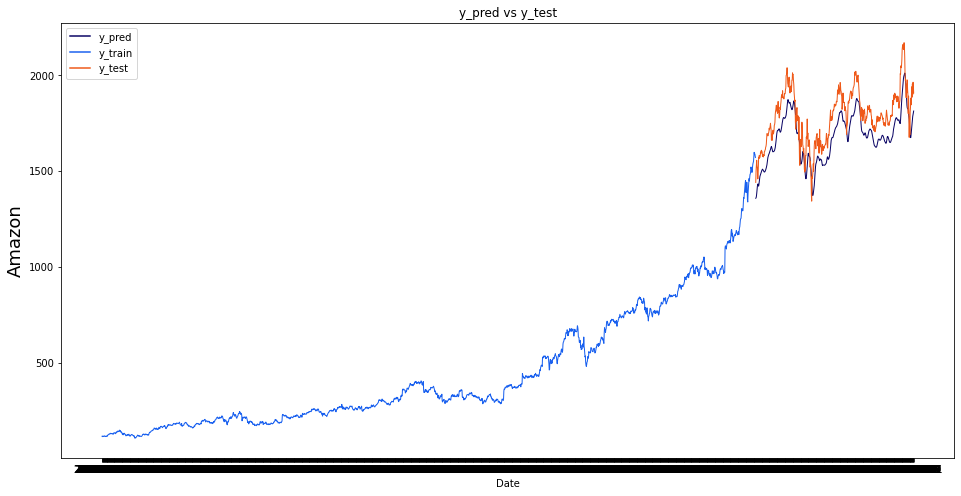

1/1 [==============================] - 0s 129ms/step
The close price for Amazon at 2022-11-24 was 1907.7
The predicted close price is 1172.4599609375 


In [43]:
# For gru
model_gru_b30 = gru(x_train)
history_gru_b30, y_pred_scaled_gru_b30 = train_gru(model_gru_b30, 30, x_train, y_train, x_test, y_test)
plot(history_gru_b30)
y_pred_gru_b30 = evaluate_model(y_pred_scaled_gru_b30, y_test)
line_plot(y_pred_gru_b30)
predict(model_gru_b30)

### Batch_size = 50

120 20 6
Epoch 1/20
41/41 [==============================] - 2s 16ms/step - loss: 0.4391 - val_loss: 0.0551
Epoch 2/20
41/41 [==============================] - 0s 12ms/step - loss: 0.0101 - val_loss: 0.0573
Epoch 3/20
41/41 [==============================] - 1s 13ms/step - loss: 0.0059 - val_loss: 0.0260
Epoch 4/20
41/41 [==============================] - 1s 13ms/step - loss: 0.0046 - val_loss: 0.0237
Epoch 5/20
41/41 [==============================] - 1s 13ms/step - loss: 0.0025 - val_loss: 0.0104
Epoch 6/20
41/41 [==============================] - 1s 13ms/step - loss: 0.0020 - val_loss: 0.0044
Epoch 7/20
41/41 [==============================] - 1s 13ms/step - loss: 0.0018 - val_loss: 0.0041
Epoch 8/20
41/41 [==============================] - 1s 13ms/step - loss: 0.0015 - val_loss: 0.0040
Epoch 9/20
41/41 [==============================] - 1s 13ms/step - loss: 0.0011 - val_loss: 0.0044
Epoch 10/20
41/41 [==============================] - 1s 13ms/step - loss: 0.0012 - val_loss: 0.0023


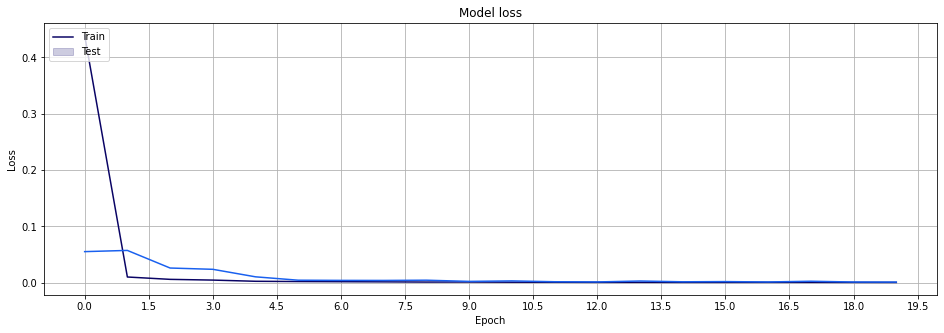

Mean Absolute Error (MAE): 54.58
Mean Absolute Percentage Error (MAPE): 3.02 %
Median Absolute Percentage Error (MDAPE): 2.57 %


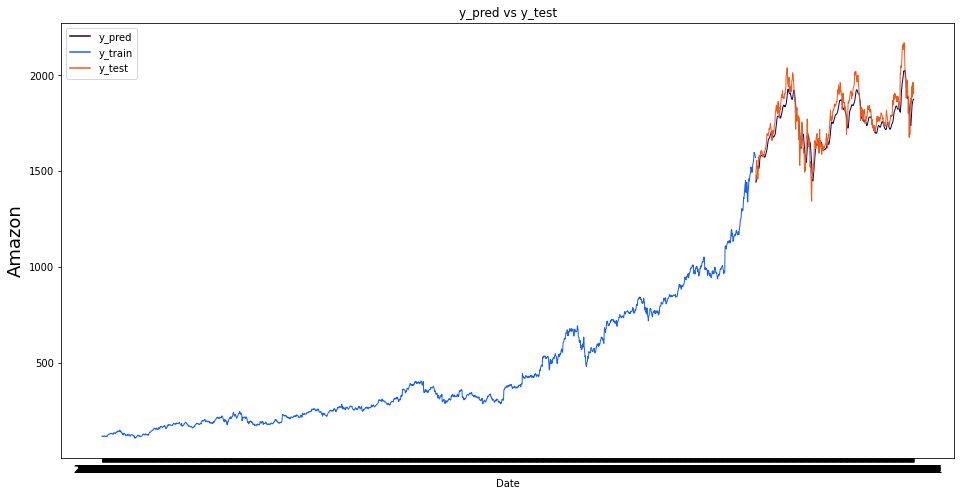

1/1 [==============================] - 0s 6ms/step
The close price for Amazon at 2022-11-24 was 1907.7
The predicted close price is -1160.1199951171875 


In [44]:
with tf.device('/cpu:0'):
    # For rnn 
    model_rnn_b50 = simple_rnn(x_train)
    history_rnn_b50, y_pred_scaled_rnn_b50 = train_rnn(model_rnn_b50, 50, x_train, y_train, x_test, y_test)
    plot(history_rnn_b50)
    y_pred_rnn_b50 = evaluate_model(y_pred_scaled_rnn_b50, y_test)
    line_plot(y_pred_rnn_b50)
    predict(model_rnn_b50)

120 20 6
Epoch 1/20


2022-11-24 16:11:40.169625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:11:40.426491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:11:40.551919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:11:40.640518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:11:40.830519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:11:40.986756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:11:41.167510: I tensorflow/core/grappler/optimizers/cust

41/41 [==============================] - ETA: 0s - loss: 0.0026

2022-11-24 16:11:43.577047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:11:43.682835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:11:43.761954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:11:43.843026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 6s 72ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 2/20
41/41 [==============================] - 1s 29ms/step - loss: 1.5079e-04 - val_loss: 0.0016
Epoch 3/20
41/41 [==============================] - 1s 27ms/step - loss: 1.3994e-04 - val_loss: 0.0025
Epoch 4/20
41/41 [==============================] - 1s 28ms/step - loss: 1.4206e-04 - val_loss: 0.0023
Epoch 5/20
41/41 [==============================] - 1s 26ms/step - loss: 1.2749e-04 - val_loss: 0.0019
Epoch 6/20
41/41 [==============================] - 1s 25ms/step - loss: 1.2261e-04 - val_loss: 0.0048
Epoch 7/20
41/41 [==============================] - 1s 26ms/step - loss: 1.3009e-04 - val_loss: 0.0069
Epoch 7: early stopping


2022-11-24 16:11:51.283947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:11:51.367937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:11:51.449770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 4/16 [======>.......................] - ETA: 0s 

2022-11-24 16:11:51.543820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 1s 21ms/step


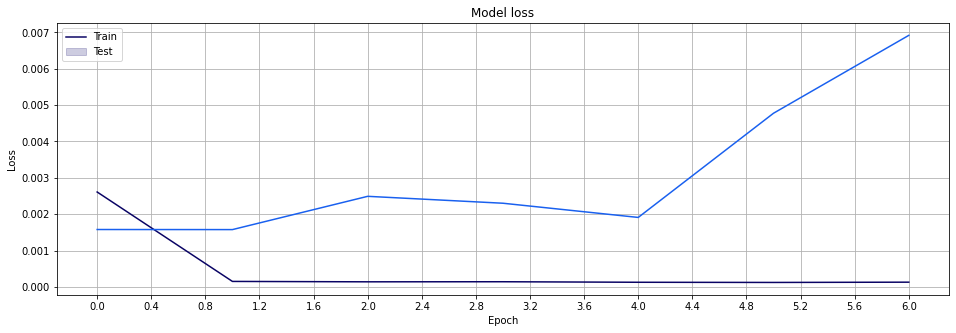

Mean Absolute Error (MAE): 150.39
Mean Absolute Percentage Error (MAPE): 8.53 %
Median Absolute Percentage Error (MDAPE): 7.72 %


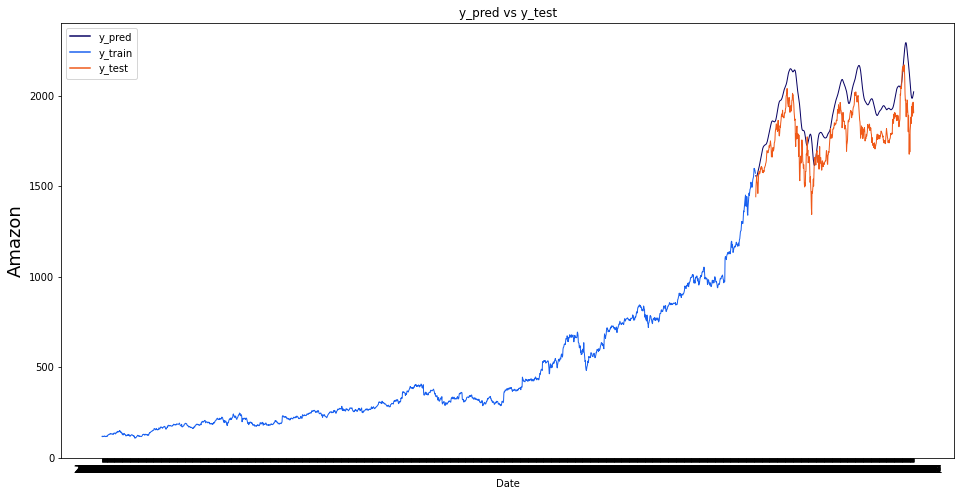

1/1 [==============================] - 0s 89ms/step
The close price for Amazon at 2022-11-24 was 1907.7
The predicted close price is 1628.4200439453125 


In [45]:
# For lstm
model_lstm_50 = lstm(x_train)
history_lstm_50, y_pred_scaled_lstm_50 = train_lstm(model_lstm_50, 50, x_train, y_train, x_test, y_test)
plot(history_lstm_50)
y_pred_lstm_50 = evaluate_model(y_pred_scaled_lstm_50, y_test)
line_plot(y_pred_lstm_50)
predict(model_lstm_50)

120 20 6
Epoch 1/20


2022-11-24 16:11:58.311566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:11:58.540208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:11:58.649181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:11:58.732735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:11:58.888396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:11:59.019110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/41 [..............................] - ETA: 1:43 - loss: 0.0332

2022-11-24 16:11:59.169925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - ETA: 0s - loss: 0.0022

2022-11-24 16:12:01.325736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:12:01.411780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:12:01.489636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:12:01.582546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 5s 67ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 2/20
41/41 [==============================] - 1s 27ms/step - loss: 8.7088e-05 - val_loss: 8.1154e-04
Epoch 3/20
41/41 [==============================] - 1s 26ms/step - loss: 8.4144e-05 - val_loss: 8.8984e-04
Epoch 4/20
41/41 [==============================] - 1s 26ms/step - loss: 8.7275e-05 - val_loss: 0.0012
Epoch 5/20
41/41 [==============================] - 1s 26ms/step - loss: 9.4178e-05 - val_loss: 7.5507e-04
Epoch 6/20
41/41 [==============================] - 1s 25ms/step - loss: 7.6845e-05 - val_loss: 7.7469e-04
Epoch 7/20
41/41 [==============================] - 1s 28ms/step - loss: 8.0211e-05 - val_loss: 8.1167e-04
Epoch 8/20
41/41 [==============================] - 1s 26ms/step - loss: 6.4811e-05 - val_loss: 8.0435e-04
Epoch 9/20
41/41 [==============================] - 1s 26ms/step - loss: 7.2144e-05 - val_loss: 7.6167e-04
Epoch 10/20
41/41 [==============================] - 1s 25ms

2022-11-24 16:12:12.959730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:12:13.035912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:12:13.119336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 4/16 [======>.......................] - ETA: 0s 

2022-11-24 16:12:13.199061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 2s 22ms/step


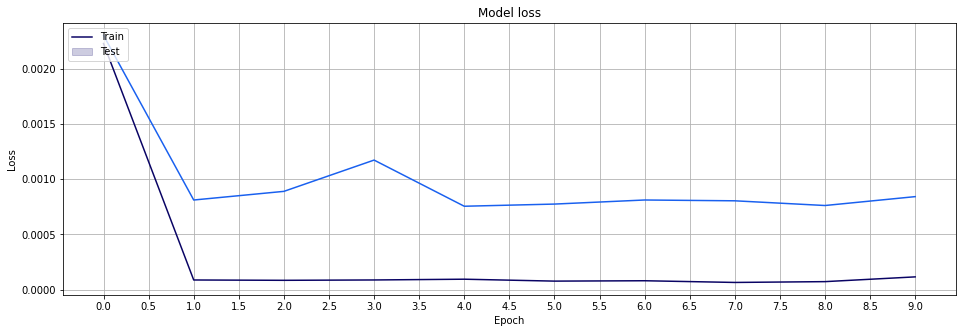

Mean Absolute Error (MAE): 46.35
Mean Absolute Percentage Error (MAPE): 2.61 %
Median Absolute Percentage Error (MDAPE): 2.16 %


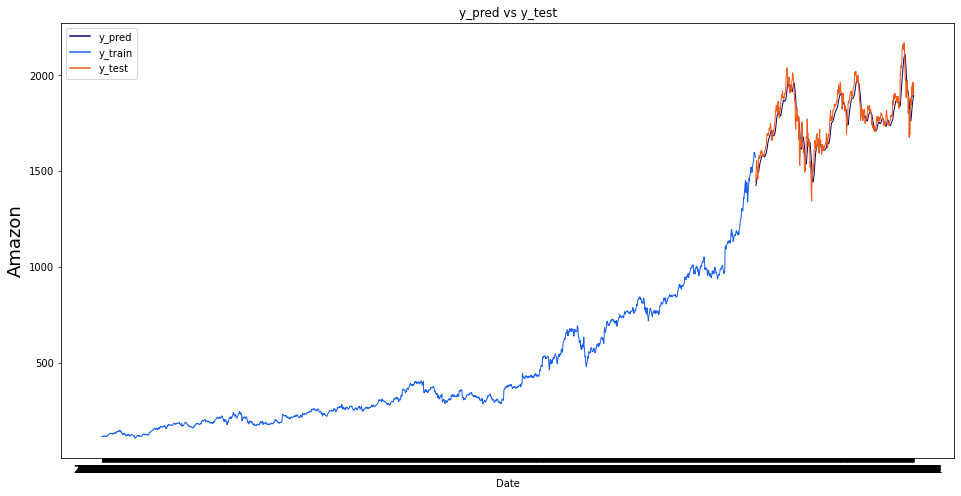

1/1 [==============================] - 0s 115ms/step
The close price for Amazon at 2022-11-24 was 1907.7
The predicted close price is 2013.4100341796875 


In [46]:
# For gru
model_gru_50 = gru(x_train)
history_gru_50, y_pred_scaled_gru_50 = train_gru(model_gru_50, 50, x_train, y_train, x_test, y_test)
plot(history_gru_50)
y_pred_gru_50 = evaluate_model(y_pred_scaled_gru_50, y_test)
line_plot(y_pred_gru_50)
predict(model_gru_50)

# Changing Sequence length with batch size 16

### Seq_length = 100

600 100 6
Epoch 1/20
99/99 [==============================] - 36s 360ms/step - loss: 2.1521 - val_loss: 0.4752
Epoch 2/20
99/99 [==============================] - 36s 369ms/step - loss: 0.0253 - val_loss: 0.3811
Epoch 3/20
99/99 [==============================] - 35s 349ms/step - loss: 0.0246 - val_loss: 0.3310
Epoch 4/20
99/99 [==============================] - 35s 356ms/step - loss: 0.0252 - val_loss: 0.5848
Epoch 5/20
99/99 [==============================] - 34s 339ms/step - loss: 0.0245 - val_loss: 0.2999
Epoch 6/20
99/99 [==============================] - 33s 336ms/step - loss: 0.0263 - val_loss: 0.4793
Epoch 7/20
99/99 [==============================] - 34s 339ms/step - loss: 0.0253 - val_loss: 0.3707
Epoch 8/20
99/99 [==============================] - 33s 334ms/step - loss: 0.0251 - val_loss: 0.3785
Epoch 9/20
99/99 [==============================] - 34s 348ms/step - loss: 0.0267 - val_loss: 0.5179
Epoch 10/20
99/99 [==============================] - 35s 351ms/step - loss: 0.026

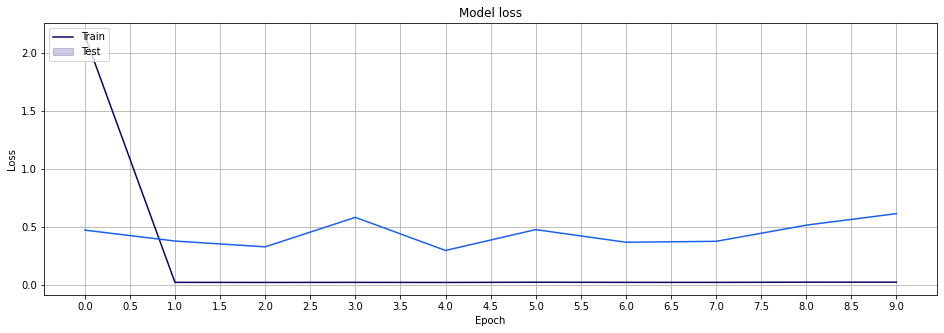

Mean Absolute Error (MAE): 1613.64
Mean Absolute Percentage Error (MAPE): 89.31 %
Median Absolute Percentage Error (MDAPE): 89.37 %


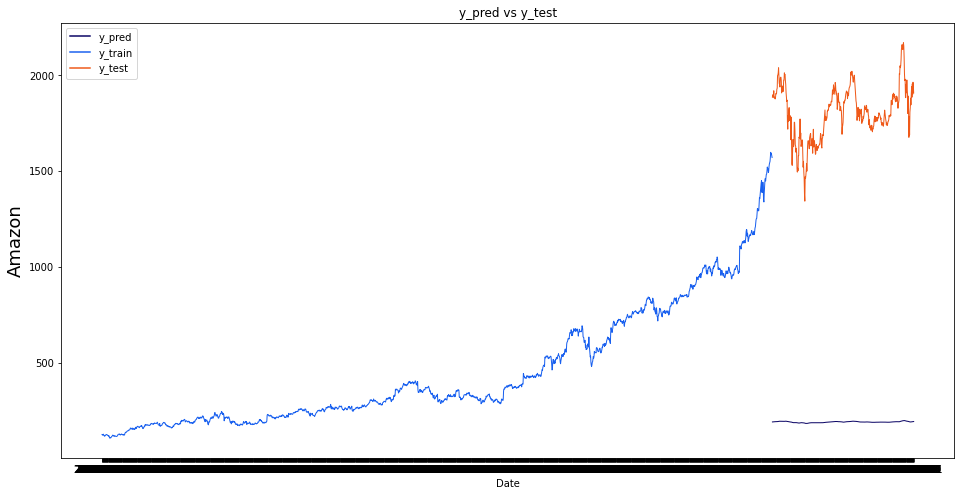

1/1 [==============================] - 0s 22ms/step
The close price for Amazon at 2022-11-24 was 1907.7
The predicted close price is 91.87999725341797 


In [47]:
sequence_length = 100
# train data and test data
x_train_s100, y_train_s100 = partition_dataset(sequence_length, train_data)
x_test_s100, y_test_s100 = partition_dataset(sequence_length, test_data)

with tf.device('/cpu:0'):
#     # For rnn
    model_rnn_s100 = simple_rnn(x_train_s100)
    history_rnn_s100, y_pred_scaled_rnn_s100 = train_rnn(model_rnn_s100, 20, x_train_s100, y_train_s100, x_test_s100, y_test_s100)
    plot(history_rnn_s100)
    y_pred_rnn_s100 = evaluate_model(y_pred_scaled_rnn_s100, y_test_s100)
    line_plot(y_pred_rnn_s100)
    predict(model_rnn_s100)

600 100 6
Epoch 1/20


2022-11-24 16:18:12.660966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:18:12.990538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:18:13.207044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:18:13.386544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:18:13.654370: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:18:13.965079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:18:14.304560: I tensorflow/core/grappler/optimizers/cust

123/123 [==============================] - ETA: 0s - loss: 0.0070

2022-11-24 16:18:34.752697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:18:34.855570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:18:35.023845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:18:35.191106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


123/123 [==============================] - 26s 186ms/step - loss: 0.0070 - val_loss: 0.0013
Epoch 2/20
123/123 [==============================] - 20s 166ms/step - loss: 1.9839e-04 - val_loss: 0.0084
Epoch 3/20
123/123 [==============================] - 21s 167ms/step - loss: 1.8806e-04 - val_loss: 0.0013
Epoch 4/20
123/123 [==============================] - 20s 166ms/step - loss: 1.5677e-04 - val_loss: 0.0012
Epoch 5/20
123/123 [==============================] - 20s 164ms/step - loss: 2.0156e-04 - val_loss: 0.0012
Epoch 6/20
123/123 [==============================] - 21s 169ms/step - loss: 7.9614e-05 - val_loss: 0.0029
Epoch 7/20
123/123 [==============================] - 21s 168ms/step - loss: 1.0568e-04 - val_loss: 0.0011
Epoch 8/20
123/123 [==============================] - 20s 161ms/step - loss: 8.8311e-05 - val_loss: 0.0013
Epoch 9/20
123/123 [==============================] - 18s 143ms/step - loss: 8.7761e-05 - val_loss: 9.8949e-04
Epoch 10/20
123/123 [===========================

2022-11-24 16:34:17.637979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:34:17.762796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:34:17.978622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:34:18.172016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 2s 103ms/step


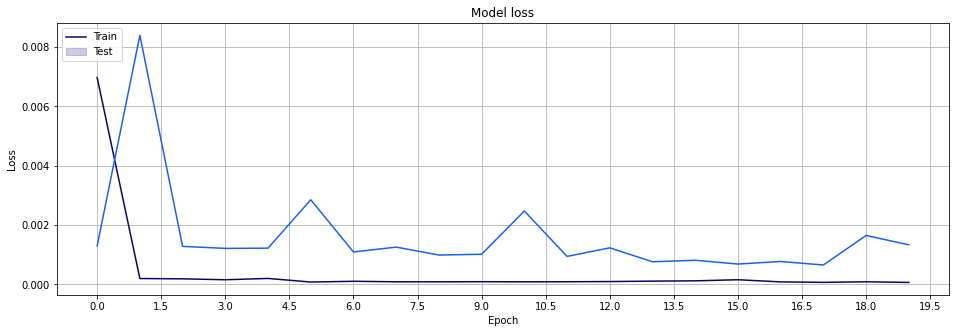

Mean Absolute Error (MAE): 65.13
Mean Absolute Percentage Error (MAPE): 3.6 %
Median Absolute Percentage Error (MDAPE): 3.49 %


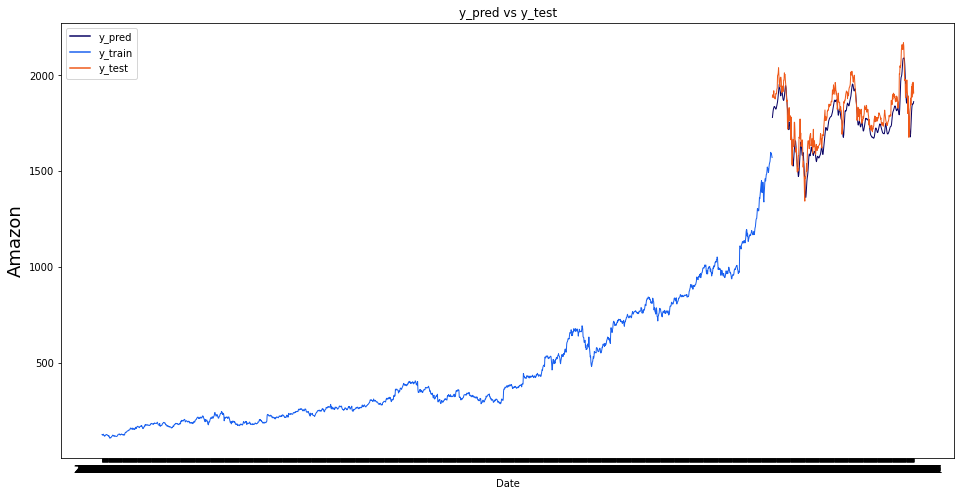

1/1 [==============================] - 0s 343ms/step
The close price for Amazon at 2022-11-24 was 1907.7
The predicted close price is 6291.64013671875 


In [48]:
# For lstm
model_lstm_s100 = lstm(x_train_s100)
history_lstm_s100, y_pred_scaled_lstm_s100 = train_lstm(model_lstm_s100, 16, x_train_s100, y_train_s100, x_test_s100, y_test_s100)
plot(history_lstm_s100)
y_pred_lstm_s100 = evaluate_model(y_pred_scaled_lstm_s100, y_test_s100)
line_plot(y_pred_lstm_s100)
predict(model_lstm_s100)

600 100 6
Epoch 1/20


2022-11-24 16:34:27.358752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:34:27.603138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:34:27.898663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:34:28.146399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:34:28.657649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:34:29.017107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:34:29.352366: I tensorflow/core/grappler/optimizers/cust

123/123 [==============================] - ETA: 0s - loss: 0.0104

2022-11-24 16:35:19.105089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:35:19.189630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:35:19.411117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:35:19.629799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


123/123 [==============================] - 58s 435ms/step - loss: 0.0104 - val_loss: 3.9305e-04
Epoch 2/20
123/123 [==============================] - 45s 365ms/step - loss: 3.3348e-05 - val_loss: 6.0886e-04
Epoch 3/20
123/123 [==============================] - 44s 358ms/step - loss: 3.4273e-05 - val_loss: 4.5043e-04
Epoch 4/20
123/123 [==============================] - 47s 379ms/step - loss: 4.0037e-05 - val_loss: 3.8199e-04
Epoch 5/20
123/123 [==============================] - 44s 361ms/step - loss: 3.9413e-05 - val_loss: 3.8061e-04
Epoch 6/20
123/123 [==============================] - 49s 403ms/step - loss: 3.8130e-05 - val_loss: 4.4086e-04
Epoch 7/20
123/123 [==============================] - 44s 361ms/step - loss: 4.9529e-05 - val_loss: 3.7398e-04
Epoch 8/20
123/123 [==============================] - 45s 368ms/step - loss: 3.8952e-05 - val_loss: 7.1512e-04
Epoch 9/20
123/123 [==============================] - 49s 396ms/step - loss: 4.6439e-05 - val_loss: 4.2169e-04
Epoch 10/20
123/

2022-11-24 16:43:49.285425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:43:49.391579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:43:49.713146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:43:50.018726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 3s 140ms/step


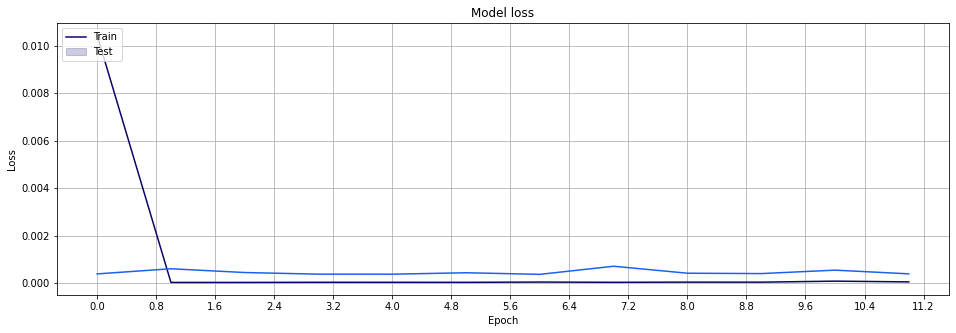

Mean Absolute Error (MAE): 30.8
Mean Absolute Percentage Error (MAPE): 1.73 %
Median Absolute Percentage Error (MDAPE): 1.24 %


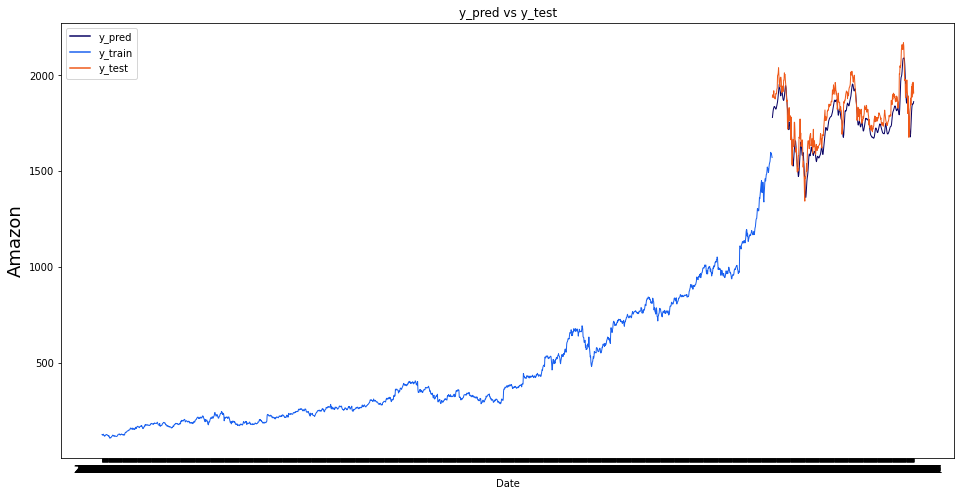

1/1 [==============================] - 1s 540ms/step
The close price for Amazon at 2022-11-24 was 1907.7
The predicted close price is 8513.51953125 


In [49]:
# For gru
model_gru_s100 = gru(x_train_s100)
history_gru_s100, y_pred_scaled_gru_s100 = train_gru(model_gru_s100, 16, x_train_s100, y_train_s100, x_test_s100, y_test_s100)
plot(history_gru_s100)
y_pred_gru_s100 = evaluate_model(y_pred_scaled_gru_s100, y_test_s100)
line_plot(y_pred_lstm_s100)
predict(model_gru_s100)

### Seq_length = 50

300 50 6
Epoch 1/20
126/126 [==============================] - 8s 58ms/step - loss: 0.8368 - val_loss: 0.0890
Epoch 2/20
126/126 [==============================] - 8s 62ms/step - loss: 0.0098 - val_loss: 0.0184
Epoch 3/20
126/126 [==============================] - 8s 65ms/step - loss: 0.0059 - val_loss: 0.0458
Epoch 4/20
126/126 [==============================] - 8s 63ms/step - loss: 0.0053 - val_loss: 0.0102
Epoch 5/20
126/126 [==============================] - 8s 66ms/step - loss: 0.0029 - val_loss: 0.0075
Epoch 6/20
126/126 [==============================] - 8s 66ms/step - loss: 0.0021 - val_loss: 0.0036
Epoch 7/20
126/126 [==============================] - 8s 64ms/step - loss: 0.0037 - val_loss: 0.0300
Epoch 8/20
126/126 [==============================] - 8s 65ms/step - loss: 0.0036 - val_loss: 0.0084
Epoch 9/20
126/126 [==============================] - 8s 66ms/step - loss: 0.0028 - val_loss: 0.0160
Epoch 10/20
126/126 [==============================] - 7s 59ms/step - loss: 0.0018

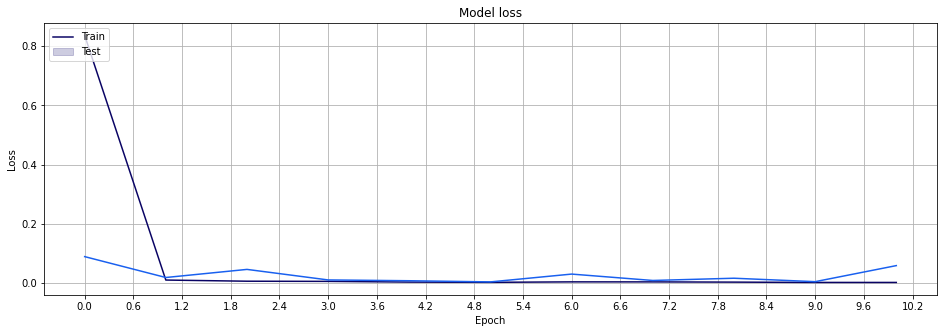

Mean Absolute Error (MAE): 438.62
Mean Absolute Percentage Error (MAPE): 23.77 %
Median Absolute Percentage Error (MDAPE): 24.05 %


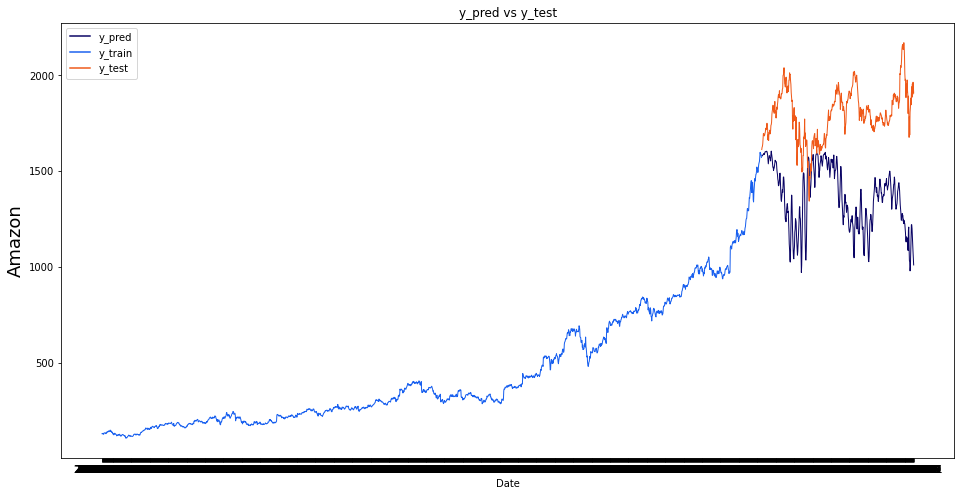

1/1 [==============================] - 0s 21ms/step
The close price for Amazon at 2022-11-24 was 1907.7
The predicted close price is 888.1900024414062 


In [50]:
# seq_length 50
sequence_length = 50
# train data and test data
x_train_s50, y_train_s50 = partition_dataset(sequence_length, train_data)
x_test_s50, y_test_s50 = partition_dataset(sequence_length, test_data)

# For rnn
with tf.device('/cpu:0'):
    model_rnn_s50 = simple_rnn(x_train_s50)
    history_rnn_s50, y_pred_scaled_rnn_s50 = train_rnn(model_rnn_s50, 16, x_train_s50, y_train_s50, x_test_s50, y_test_s50)
    plot(history_rnn_s50)
    y_pred_rnn_s50 = evaluate_model(y_pred_scaled_rnn_s50, y_test_s50)
    line_plot(y_pred_rnn_s50)
    predict(model_rnn_s50)

300 50 6
Epoch 1/20


2022-11-24 16:45:34.377127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:45:34.655569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:45:34.844702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:45:35.038507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:45:35.293066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:45:35.500413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:45:35.724209: I tensorflow/core/grappler/optimizers/cust

126/126 [==============================] - ETA: 0s - loss: 0.0015

2022-11-24 16:45:43.024855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:45:43.115710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:45:43.252389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:45:43.388853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 12s 69ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 2/20
126/126 [==============================] - 6s 45ms/step - loss: 1.5813e-04 - val_loss: 0.0035
Epoch 3/20
126/126 [==============================] - 5s 43ms/step - loss: 1.5398e-04 - val_loss: 0.0031
Epoch 4/20
126/126 [==============================] - 6s 44ms/step - loss: 2.9824e-04 - val_loss: 0.0017
Epoch 5/20
126/126 [==============================] - 6s 44ms/step - loss: 8.6884e-05 - val_loss: 0.0011
Epoch 6/20
126/126 [==============================] - 6s 44ms/step - loss: 9.3237e-05 - val_loss: 0.0032
Epoch 7/20
126/126 [==============================] - 6s 46ms/step - loss: 9.6781e-05 - val_loss: 9.6930e-04
Epoch 8/20
126/126 [==============================] - 6s 45ms/step - loss: 8.9492e-05 - val_loss: 8.6749e-04
Epoch 9/20
126/126 [==============================] - 6s 45ms/step - loss: 2.4524e-04 - val_loss: 8.0938e-04
Epoch 10/20
126/126 [==============================] - 6s

2022-11-24 16:47:22.524499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:47:22.624295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:47:22.775925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:47:22.943432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 2s 48ms/step


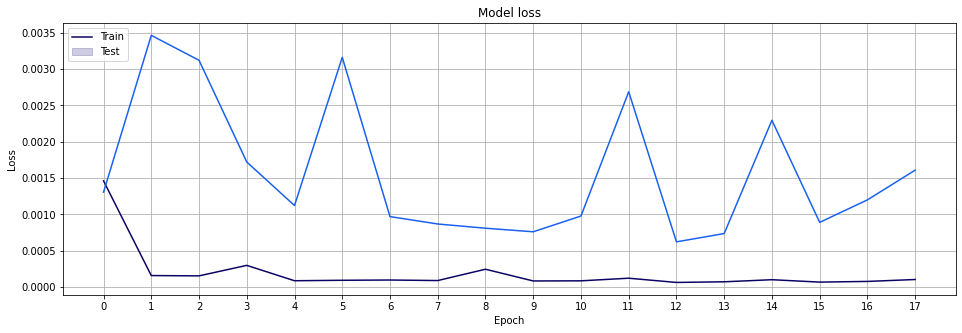

Mean Absolute Error (MAE): 74.25
Mean Absolute Percentage Error (MAPE): 4.11 %
Median Absolute Percentage Error (MDAPE): 4.06 %


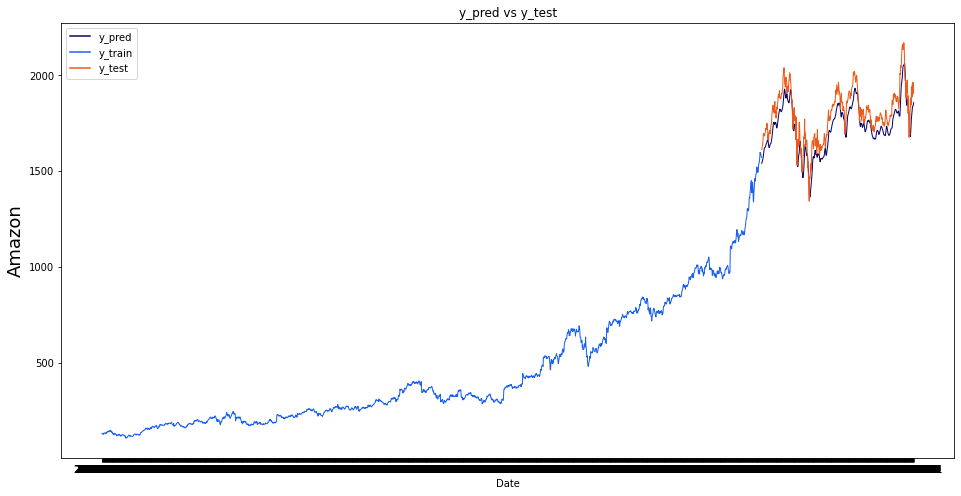

1/1 [==============================] - 0s 186ms/step
The close price for Amazon at 2022-11-24 was 1907.7
The predicted close price is 4912.1201171875 


In [51]:
# For lstm
model_lstm_s50 = lstm(x_train_s50)
history_lstm_s50, y_pred_scaled_lstm_s50 = train_lstm(model_lstm_s50, 16, x_train_s50, y_train_s50, x_test_s50, y_test_s50)
plot(history_lstm_s50)
y_pred_lstm_s50 = evaluate_model(y_pred_scaled_lstm_s50, y_test_s50)
line_plot(y_pred_lstm_s50)
predict(model_lstm_s50)

300 50 6
Epoch 1/20


2022-11-24 16:47:31.828435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:47:32.132345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:47:32.420715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:47:32.600029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:47:32.830262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:47:33.052663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:47:33.338034: I tensorflow/core/grappler/optimizers/cust

126/126 [==============================] - ETA: 0s - loss: 0.0018

2022-11-24 16:47:43.663888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:47:43.737089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:47:43.885200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:47:44.029910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


126/126 [==============================] - 16s 94ms/step - loss: 0.0018 - val_loss: 9.3148e-04
Epoch 2/20
126/126 [==============================] - 9s 73ms/step - loss: 5.8354e-05 - val_loss: 6.2941e-04
Epoch 3/20
126/126 [==============================] - 10s 79ms/step - loss: 8.1248e-05 - val_loss: 6.8204e-04
Epoch 4/20
126/126 [==============================] - 10s 77ms/step - loss: 1.0962e-04 - val_loss: 0.0016
Epoch 5/20
126/126 [==============================] - 10s 77ms/step - loss: 8.7349e-05 - val_loss: 9.5822e-04
Epoch 6/20
126/126 [==============================] - 9s 75ms/step - loss: 8.1471e-05 - val_loss: 9.9631e-04
Epoch 7/20
126/126 [==============================] - 9s 75ms/step - loss: 8.6723e-05 - val_loss: 6.8731e-04
Epoch 7: early stopping


2022-11-24 16:48:43.127384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:48:43.204688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:48:43.387541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:48:43.556673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 2s 56ms/step


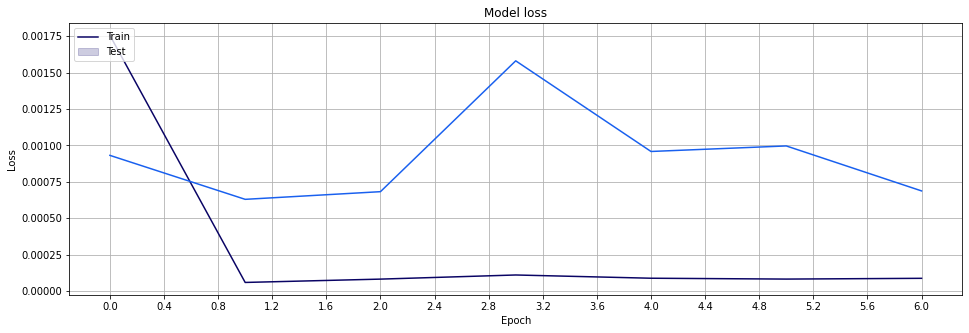

Mean Absolute Error (MAE): 42.41
Mean Absolute Percentage Error (MAPE): 2.38 %
Median Absolute Percentage Error (MDAPE): 1.93 %


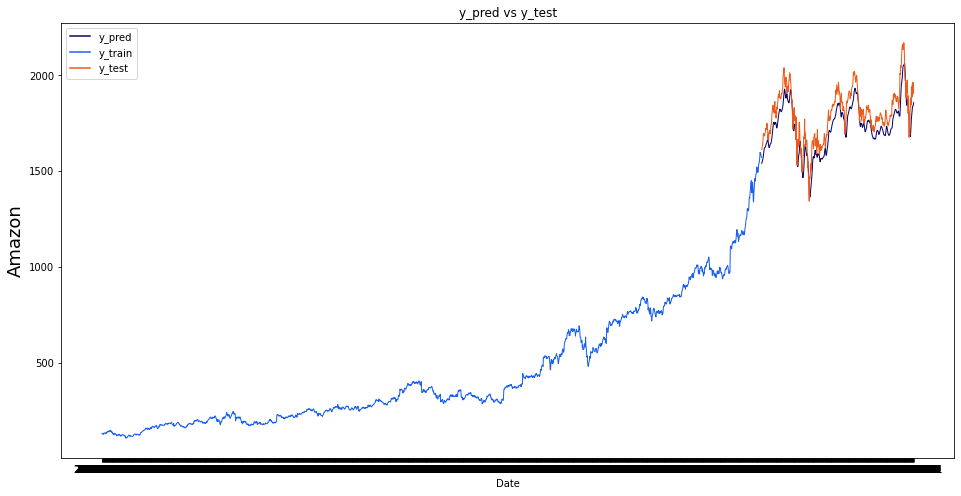

1/1 [==============================] - 0s 252ms/step
The close price for Amazon at 2022-11-24 was 1907.7
The predicted close price is 3619.090087890625 


In [52]:
# For gru
model_gru_s50 = gru(x_train_s50)
history_gru_s50, y_pred_scaled_gru_s50 = train_gru(model_gru_s50, 16, x_train_s50, y_train_s50, x_test_s50, y_test_s50)
plot(history_gru_s50)
y_pred_gru_s50 = evaluate_model(y_pred_scaled_gru_s50, y_test_s50)
line_plot(y_pred_lstm_s50)
predict(model_gru_s50)

# Different Architecture

### 2 Layers

In [53]:
sequence_length = 20

120 20 6
Epoch 1/20
128/128 [==============================] - 1s 6ms/step - loss: 0.0239 - val_loss: 0.0086
Epoch 2/20
128/128 [==============================] - 1s 5ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 3/20
128/128 [==============================] - 1s 5ms/step - loss: 9.5845e-04 - val_loss: 0.0018
Epoch 4/20
128/128 [==============================] - 1s 5ms/step - loss: 7.5485e-04 - val_loss: 0.0014
Epoch 5/20
128/128 [==============================] - 1s 5ms/step - loss: 3.9944e-04 - val_loss: 5.8396e-04
Epoch 6/20
128/128 [==============================] - 1s 5ms/step - loss: 4.1864e-04 - val_loss: 5.6776e-04
Epoch 7/20
128/128 [==============================] - 1s 5ms/step - loss: 4.9585e-04 - val_loss: 0.0033
Epoch 8/20
128/128 [==============================] - 1s 5ms/step - loss: 9.0052e-04 - val_loss: 0.0012
Epoch 9/20
128/128 [==============================] - 1s 5ms/step - loss: 4.5682e-04 - val_loss: 5.3072e-04
Epoch 10/20
128/128 [==============================

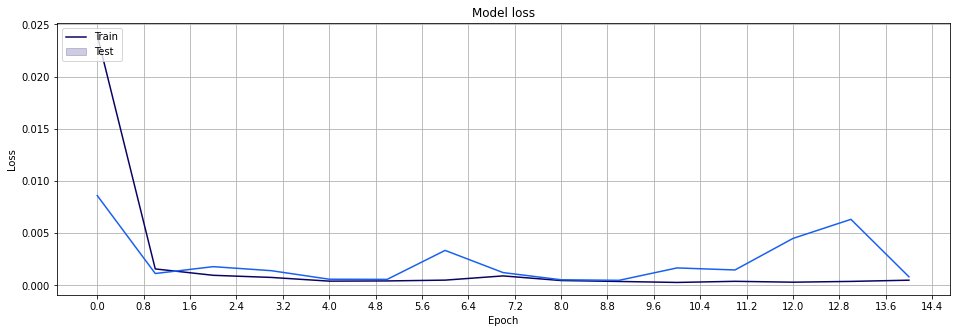

Mean Absolute Error (MAE): 48.95
Mean Absolute Percentage Error (MAPE): 2.7 %
Median Absolute Percentage Error (MDAPE): 2.45 %


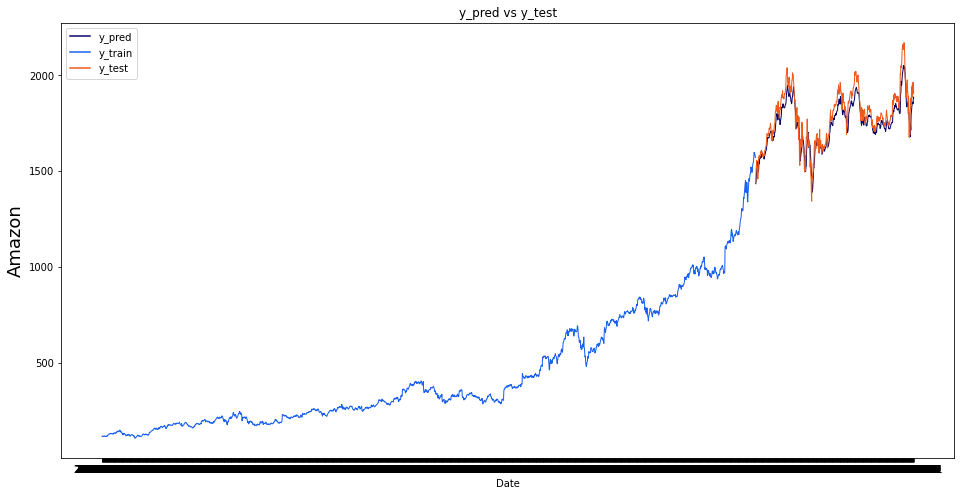

1/1 [==============================] - 0s 7ms/step
The close price for Amazon at 2022-11-24 was 1907.7
The predicted close price is -999.469970703125 


In [54]:
with tf.device('/cpu:0'): 
    # batch_size 16
    model_rnn_l2 = simple_rnn(x_train, layer = 2)
    history_rnn_l2, y_pred_scaled_rnn_l2 = train_rnn(model_rnn_l2, 16, x_train, y_train, x_test, y_test)
    plot(history_rnn_l2)
    y_pred_rnn_l2 = evaluate_model(y_pred_scaled_rnn_l2, y_test)
    line_plot(y_pred_rnn_l2)
    predict(model_rnn_l2)

120 20 6
Epoch 1/20


2022-11-24 16:49:06.446027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:49:06.645061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:49:06.804379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:49:07.040342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:49:07.333986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


128/128 [==============================] - ETA: 0s - loss: 0.0016

2022-11-24 16:49:11.024368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:49:11.083079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:49:11.197306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


128/128 [==============================] - 7s 34ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 2/20
128/128 [==============================] - 2s 18ms/step - loss: 8.9626e-05 - val_loss: 0.0052
Epoch 3/20
128/128 [==============================] - 2s 19ms/step - loss: 8.7003e-05 - val_loss: 0.0030
Epoch 4/20
128/128 [==============================] - 2s 18ms/step - loss: 8.4089e-05 - val_loss: 0.0058
Epoch 5/20
128/128 [==============================] - 2s 18ms/step - loss: 1.1419e-04 - val_loss: 0.0041
Epoch 6/20
128/128 [==============================] - 2s 18ms/step - loss: 7.7983e-05 - val_loss: 0.0019
Epoch 6: early stopping


2022-11-24 16:49:23.796023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:49:23.863078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:49:23.975557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 1s 19ms/step


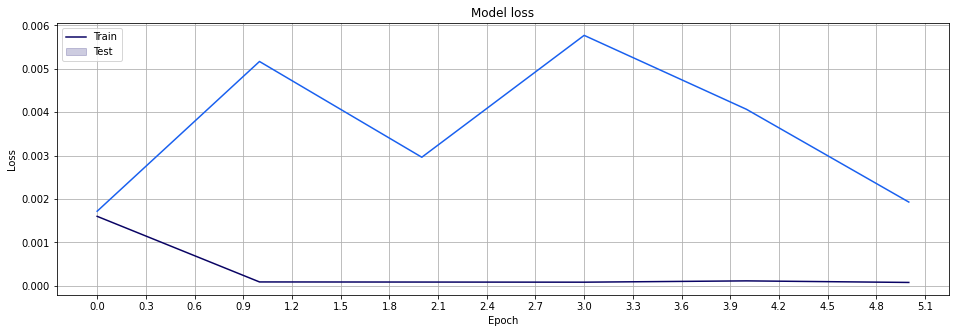

Mean Absolute Error (MAE): 73.27
Mean Absolute Percentage Error (MAPE): 4.16 %
Median Absolute Percentage Error (MDAPE): 3.46 %


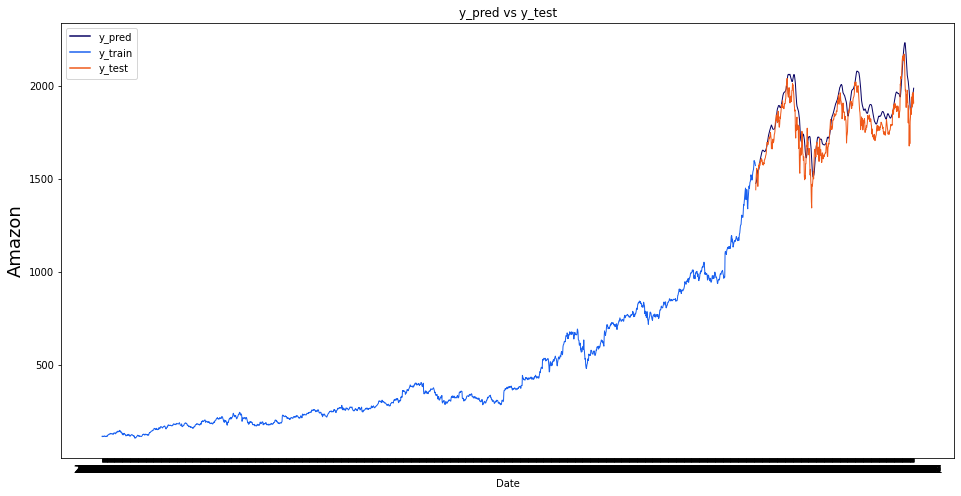

1/1 [==============================] - 0s 98ms/step
The close price for Amazon at 2022-11-24 was 1907.7
The predicted close price is 2549.8798828125 


In [55]:
# lstm
model_lstm_l2 = lstm(x_train, layer = 2)
history_lstm_l2, y_pred_scaled_lstm_l2 = train_lstm(model_lstm_l2, 16, x_train, y_train, x_test, y_test)
plot(history_lstm_l2)
y_pred_lstm_l2 = evaluate_model(y_pred_scaled_lstm_l2, y_test)
line_plot(y_pred_lstm_l2)
predict(model_lstm_l2)

120 20 6
Epoch 1/20


2022-11-24 16:49:30.255974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:49:30.437315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:49:30.598322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:49:30.825621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:49:31.070944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


128/128 [==============================] - ETA: 0s - loss: 0.0013

2022-11-24 16:49:34.627663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:49:34.687292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:49:34.797064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


128/128 [==============================] - 6s 32ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 2/20
128/128 [==============================] - 2s 19ms/step - loss: 1.0546e-04 - val_loss: 0.0037
Epoch 3/20
128/128 [==============================] - 2s 19ms/step - loss: 1.1044e-04 - val_loss: 0.0022
Epoch 4/20
128/128 [==============================] - 2s 18ms/step - loss: 9.5496e-05 - val_loss: 0.0013
Epoch 5/20
128/128 [==============================] - 2s 18ms/step - loss: 9.3010e-05 - val_loss: 0.0028
Epoch 6/20
128/128 [==============================] - 2s 18ms/step - loss: 9.3826e-05 - val_loss: 9.9476e-04
Epoch 7/20
128/128 [==============================] - 2s 18ms/step - loss: 8.7886e-05 - val_loss: 0.0029
Epoch 8/20
128/128 [==============================] - 2s 18ms/step - loss: 8.0562e-05 - val_loss: 0.0037
Epoch 9/20
128/128 [==============================] - 2s 18ms/step - loss: 1.3041e-04 - val_loss: 0.0052
Epoch 10/20
128/128 [==============================] - 2s 18ms/ste

2022-11-24 16:49:58.974540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:49:59.034045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:49:59.147042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 1s 21ms/step


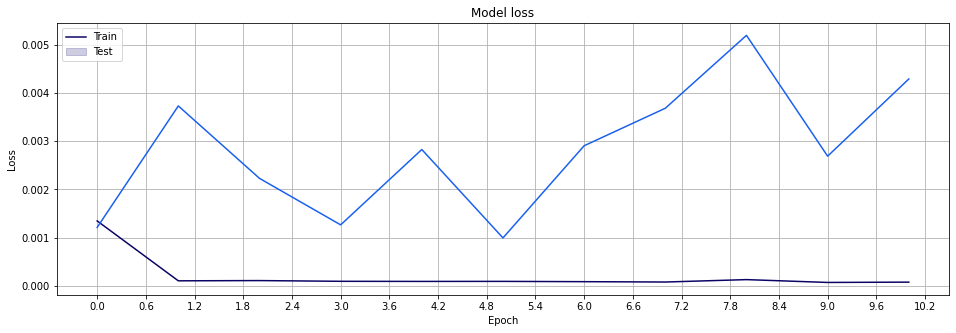

Mean Absolute Error (MAE): 122.76
Mean Absolute Percentage Error (MAPE): 6.93 %
Median Absolute Percentage Error (MDAPE): 6.47 %


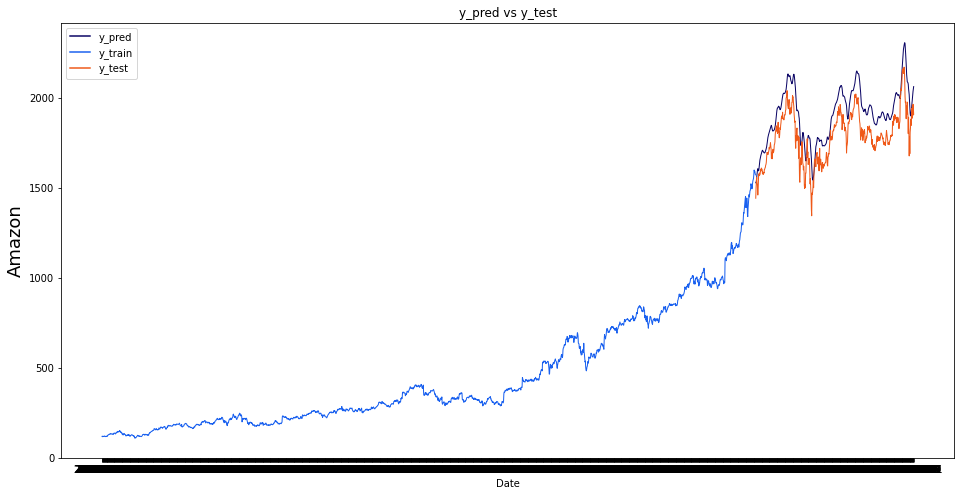

1/1 [==============================] - 0s 108ms/step
The close price for Amazon at 2022-11-24 was 1907.7
The predicted close price is 2741.570068359375 


In [56]:
# batch_size 16
model_gru_l2 = gru(x_train, layer = 2)
history_gru_l2, y_pred_scaled_gru_l2 = train_gru(model_gru_l2, 16, x_train, y_train, x_test, y_test)
plot(history_gru_l2)
y_pred_gru_l2 = evaluate_model(y_pred_scaled_gru_l2, y_test)
line_plot(y_pred_gru_l2)
predict(model_gru_l2)

### 1 layer

120 20 6
Epoch 1/20
128/128 [==============================] - 1s 3ms/step - loss: 0.0050 - val_loss: 0.0031
Epoch 2/20
128/128 [==============================] - 0s 2ms/step - loss: 8.5953e-05 - val_loss: 8.4741e-04
Epoch 3/20
128/128 [==============================] - 0s 2ms/step - loss: 6.8931e-05 - val_loss: 6.7272e-04
Epoch 4/20
128/128 [==============================] - 0s 2ms/step - loss: 5.9798e-05 - val_loss: 5.2125e-04
Epoch 5/20
128/128 [==============================] - 0s 2ms/step - loss: 5.7967e-05 - val_loss: 5.4902e-04
Epoch 6/20
128/128 [==============================] - 0s 2ms/step - loss: 6.7794e-05 - val_loss: 9.2792e-04
Epoch 7/20
128/128 [==============================] - 0s 2ms/step - loss: 7.8356e-05 - val_loss: 4.3083e-04
Epoch 8/20
128/128 [==============================] - 0s 2ms/step - loss: 4.4650e-05 - val_loss: 8.9565e-04
Epoch 9/20
128/128 [==============================] - 0s 2ms/step - loss: 4.2264e-05 - val_loss: 6.6044e-04
Epoch 10/20
128/128 [======

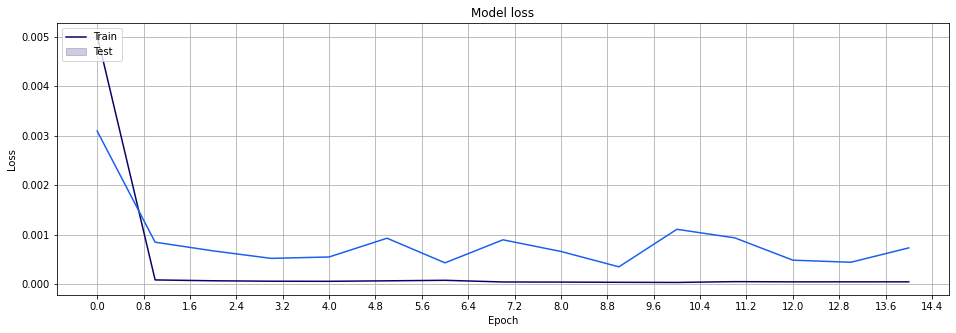

Mean Absolute Error (MAE): 45.72
Mean Absolute Percentage Error (MAPE): 2.62 %
Median Absolute Percentage Error (MDAPE): 2.26 %


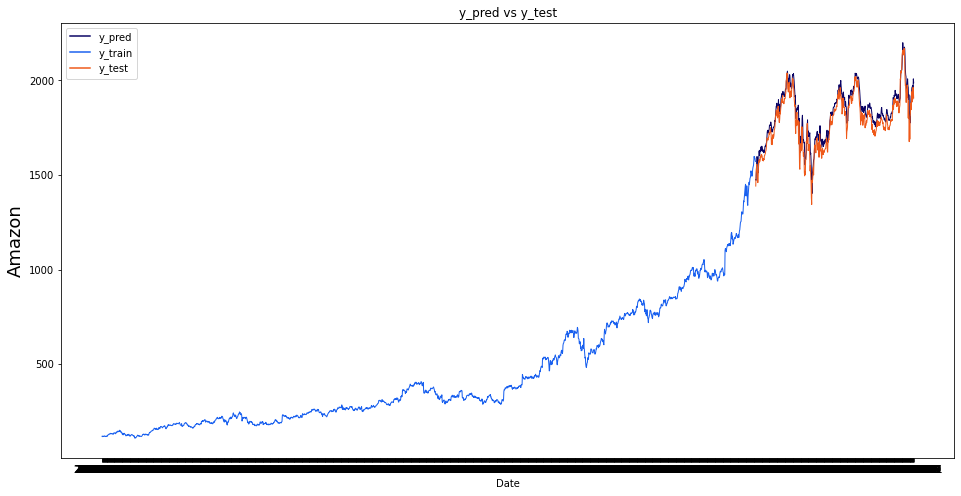

1/1 [==============================] - 0s 5ms/step
The close price for Amazon at 2022-11-24 was 1907.7
The predicted close price is 5371.27001953125 


In [57]:
with tf.device('/cpu:0'): 
    # batch_size 16
    model_rnn_l1 = simple_rnn(x_train, layer = 1)
    history_rnn_l1, y_pred_scaled_rnn_l1 = train_rnn(model_rnn_l1, 16, x_train, y_train, x_test, y_test)
    plot(history_rnn_l1)
    y_pred_rnn_l1 = evaluate_model(y_pred_scaled_rnn_l1, y_test)
    line_plot(y_pred_rnn_l1)
    predict(model_rnn_l1)

120 20 6
Epoch 1/20


2022-11-24 16:50:14.549742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:50:14.646784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:50:14.897335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


128/128 [==============================] - ETA: 0s - loss: 0.0017

2022-11-24 16:50:17.048645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:50:17.086430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


128/128 [==============================] - 4s 19ms/step - loss: 0.0017 - val_loss: 7.8818e-04
Epoch 2/20
128/128 [==============================] - 2s 12ms/step - loss: 6.0288e-05 - val_loss: 9.5711e-04
Epoch 3/20
128/128 [==============================] - 1s 12ms/step - loss: 5.5669e-05 - val_loss: 7.2667e-04
Epoch 4/20
128/128 [==============================] - 1s 11ms/step - loss: 6.2507e-05 - val_loss: 0.0011
Epoch 5/20
128/128 [==============================] - 2s 12ms/step - loss: 5.0987e-05 - val_loss: 0.0017
Epoch 6/20
128/128 [==============================] - 1s 11ms/step - loss: 5.2199e-05 - val_loss: 6.5960e-04
Epoch 7/20
128/128 [==============================] - 1s 11ms/step - loss: 5.7291e-05 - val_loss: 8.9464e-04
Epoch 8/20
128/128 [==============================] - 1s 11ms/step - loss: 5.3104e-05 - val_loss: 0.0012
Epoch 9/20
128/128 [==============================] - 1s 11ms/step - loss: 5.1132e-05 - val_loss: 6.0370e-04
Epoch 10/20
128/128 [=========================

2022-11-24 16:50:46.543079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:50:46.581391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 1s 11ms/step


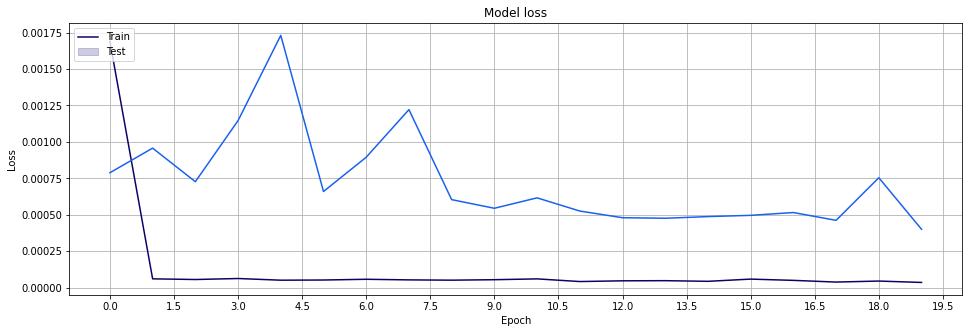

Mean Absolute Error (MAE): 29.66
Mean Absolute Percentage Error (MAPE): 1.69 %
Median Absolute Percentage Error (MDAPE): 1.14 %


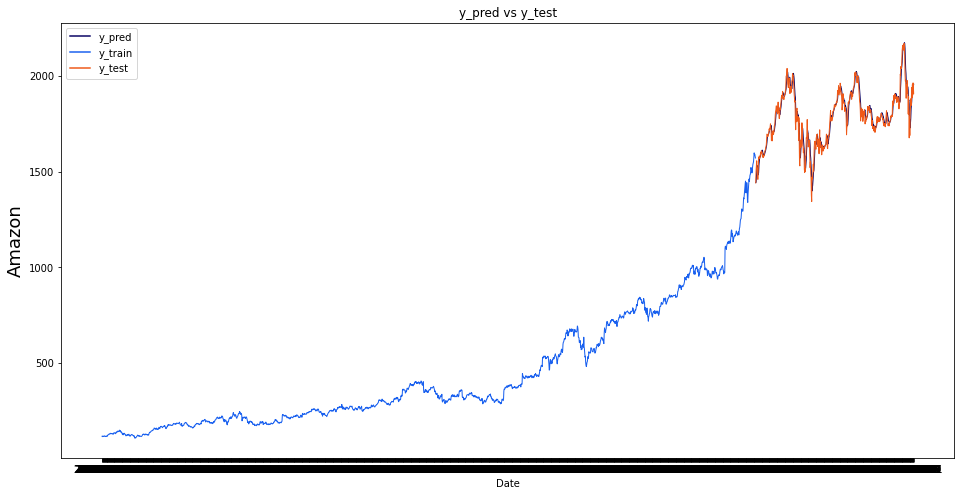

1/1 [==============================] - 0s 98ms/step
The close price for Amazon at 2022-11-24 was 1907.7
The predicted close price is 4817.0400390625 


In [58]:
# lstm
model_lstm_l1 = lstm(x_train, layer = 1)
history_lstm_l1, y_pred_scaled_lstm_l1 = train_lstm(model_lstm_l1, 16, x_train, y_train, x_test, y_test)
plot(history_lstm_l1)
y_pred_lstm_l1 = evaluate_model(y_pred_scaled_lstm_l1, y_test)
line_plot(y_pred_lstm_l1)
predict(model_lstm_l1)

120 20 6
Epoch 1/20


2022-11-24 16:50:53.338801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:50:53.437386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:50:53.728142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


128/128 [==============================] - ETA: 0s - loss: 0.0016

2022-11-24 16:50:55.996393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:50:56.035413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


128/128 [==============================] - 4s 20ms/step - loss: 0.0016 - val_loss: 8.2122e-04
Epoch 2/20
128/128 [==============================] - 1s 11ms/step - loss: 6.8992e-05 - val_loss: 0.0012
Epoch 3/20
128/128 [==============================] - 1s 11ms/step - loss: 6.0871e-05 - val_loss: 9.6426e-04
Epoch 4/20
128/128 [==============================] - 1s 11ms/step - loss: 5.9847e-05 - val_loss: 8.4113e-04
Epoch 5/20
128/128 [==============================] - 1s 11ms/step - loss: 6.8202e-05 - val_loss: 7.3914e-04
Epoch 6/20
128/128 [==============================] - 1s 11ms/step - loss: 6.3225e-05 - val_loss: 7.5397e-04
Epoch 7/20
128/128 [==============================] - 1s 11ms/step - loss: 5.5321e-05 - val_loss: 7.0074e-04
Epoch 8/20
128/128 [==============================] - 2s 12ms/step - loss: 5.2179e-05 - val_loss: 6.9142e-04
Epoch 9/20
128/128 [==============================] - 1s 11ms/step - loss: 7.0308e-05 - val_loss: 6.8368e-04
Epoch 10/20
128/128 [=================

2022-11-24 16:51:15.243032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-24 16:51:15.275934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 1s 11ms/step


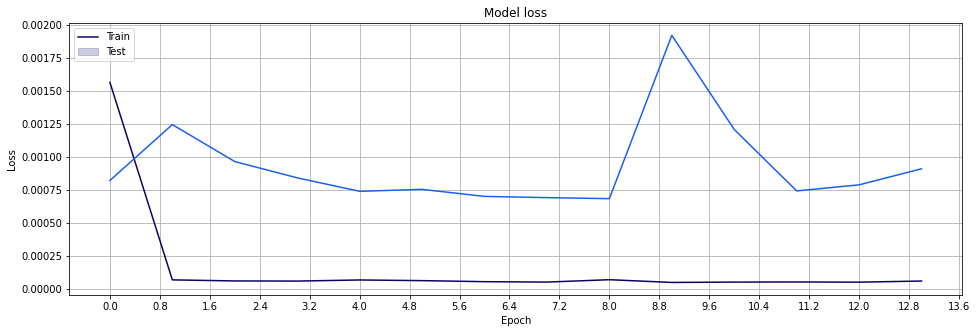

Mean Absolute Error (MAE): 49.69
Mean Absolute Percentage Error (MAPE): 2.83 %
Median Absolute Percentage Error (MDAPE): 2.4 %


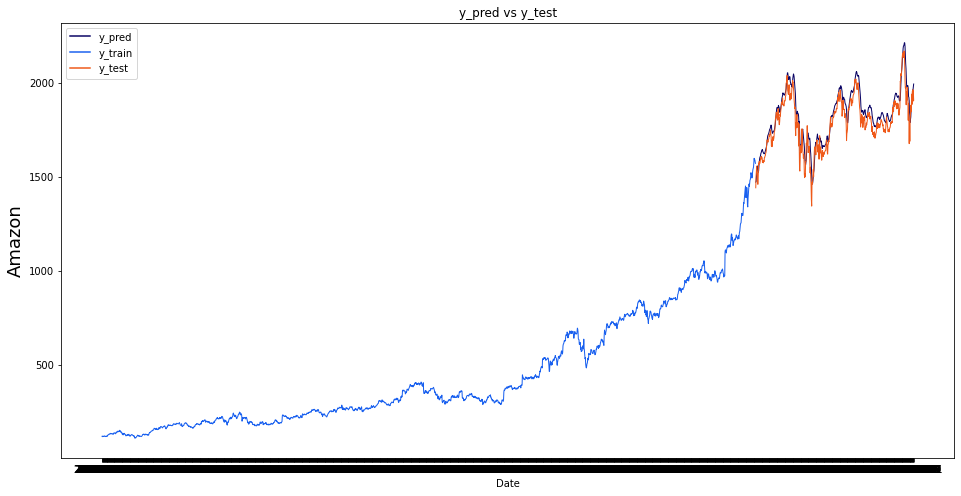

1/1 [==============================] - 0s 51ms/step
The close price for Amazon at 2022-11-24 was 1907.7
The predicted close price is 3005.159912109375 


In [59]:
# gru
model_gru_l1 = gru(x_train, layer = 1)
history_gru_l1, y_pred_scaled_gru_l1 = train_gru(model_gru_l1, 16, x_train, y_train, x_test, y_test)
plot(history_gru_l1)
y_pred_gru_l1 = evaluate_model(y_pred_scaled_gru_l1, y_test)
line_plot(y_pred_gru_l1)
predict(model_gru_l1)